In [60]:
%reload_ext watermark
%matplotlib inline

import os
from scipy.stats import mannwhitneyu, zscore
from sklearn.linear_model import LogisticRegression
from contextlib import suppress
from metapool.metapool import *
from metapool import (make_sample_sheet, requires_dilution, dilute_gDNA,
                      find_threshold, autopool, extract_stats_metadata)
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2024-04-01T15:13:28.756339-07:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

metapool    : 0+untagged.169.g726dbe1.dirty
sample_sheet: 0.13.0
openpyxl    : 3.0.10

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: Rodolfos-MacBook-Pro-2.local

numpy     : 1.26.3
pandas    : 2.1.4
json      : 2.0.9
re        : 2.2.1
matplotlib: 3.7.3
seaborn   : 0.12.2



# Knight Lab metatranscriptomics pipeline notebook

### What is it?

This Jupyter Notebook allows you to automatically produce most of the files you need for completing the Knight Lab metatranscriptomics sequencing pipeline, which build upon the shotgun metagenomics pipeline. 

Hopefully, this will not only make it much easier to generate these files, but also keep our information more accurate.

### Here's how it should work.

You'll start out with a **basic plate map**, which just links each sample to it's approprite well location, and tracks sample extraction metadata

Then you'll add the output of the MiniPico assay of sample RNA concentration and gDNA concentration which will enable to you to decide if you need to do a dilution of the extracted nucleic acid prior to DNAse treatment. The DNAse enzyme used in the pipeline has recommended ranges of gDNA to ensure full digestion of the dsDNA. The notebook will also allow you to visualize these concentrations on the plate, allowing you to double check the plate map and DNA concentration read.

Next you'll automatically assign barcodes to each sample, producing an **index pick list** for barcode addition prior to PCR.

After finishing the cDNA library prep, you'll measure library concentration with MiniPico. This quant data file will then be read in and used to estimate and visualize pooling parameters, producing a **pooling pick list**. For the iSeqnorm, an *equal volume pool* is produced.

After sequencing the equal volume pool, a file with the read counts associated with all samples will be imported and used to calculate pooling volumes to generate a sequence count normalized **final pooling pick list**.

Lastly, the per-sample information from the whole run can be combined to automatically produce **sample sheet** to demultiplex sequence data from Illumina sequencers.

# Workflow for Quality Control (QC) of the total nucleic acid extraction

This portion of the notebook will read in the output of the MiniPico quantification assays (gDNA / RNA)

As inputs, it requires:
1. A tab-delimited row-wise plate map that indicates the sample name, well location, and blank status of each sample on the 384 well plate.

You can use this google sheet template to generate your plate map:
https://docs.google.com/spreadsheets/d/1xPjB6iR3brGeG4bm2un4ISSsTDxFw5yME09bKqz0XNk/edit?usp=sharing

The workflow then:
1. reads in the plate map and constructs a dataframe
2. imports quant files and merged DNA/RNA concentration data. 

## Step 1: read in plate map

**Enter the correct path to the plate map file**. This will serve as the plate map for relating all subsequent information.

In [61]:
plate_map_fp = './test_data/Plate_Maps/2024_NPH_Plates_3-6_plate_map.tsv'

if not os.path.isfile(plate_map_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the plate map**. It should look something like this:

```
Sample	Row	Col	Blank
GLY_01_012	A	1	False
GLY_14_034	B	1	False
GLY_11_007	C	1	False
GLY_28_018	D	1	False
GLY_25_003	E	1	False
GLY_06_106	F	1	False
GLY_07_011	G	1	False
GLY_18_043	H	1	False
GLY_28_004	I	1	False
```
**Make sure there a no duplicate IDs**. If each sample doesn't have a different name, an **error** will be thrown and you won't be able to generate a sample sheet.

In [62]:
##need to specify the directory for qiita.oauth.cfg
plate_df = read_plate_map_csv(plate_map_fp)
plate_df.head()

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:269: UserWarning: No qiita_oauth2_conf_fp set so not checking plate_map and Qiita study overlap
  warnings.warn('No qiita_oauth2_conf_fp set so not checking plate_map '


Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  
0         A1                      Q1   A1  
1         B1                      Q1   C1  
2         C1                      Q1   E1  
3         D1                      Q1   G1  
4         E1                      Q1   I1

## Step 2: read in DNA/RNA concentrations and add to plate map

**Enter the correct path to the Pico DNA concentration output**. This should be a txt-formatted file produced by the MiniPico assay on the condensed, 384-well plate. 

In [63]:
sample_dna_concs_fp = './test_data/Quant/MiniPico/2024_NPH_Plates_3-5_gDNA_quant.txt'

if not os.path.isfile(sample_dna_concs_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the DNA concentration output file**. It should be a .txt file and should look something like this:
    
```
##BLOCKS= 1
Group: Unknowns
Sample	Wells	RFU_Values	Concentration	Mean_Conc	SD	CV	Dilution	AdjConc	
01	A1	16352.000	0.434	0.434	0.000	0.0			
02	C1	26061758.000	37.588	37.588	0.000	0.0			
03	E1	1483519.000	2.527	2.527	0.000	0.0			
04	G1	3015184.000	4.712	4.712	0.000	0.0			
05	I1	16574.000	0.434	0.434	0.000	0.0			
06	K1	14988.000	0.432	0.432	0.000	0.0			
```

In [64]:
sample_dna_concs = read_pico_csv(sample_dna_concs_fp, plate_reader='SpectraMax_i3x',conc_col_name='Sample DNA Concentration')

plate_df = pd.merge(plate_df, sample_dna_concs, on='Well')

well_col = 'Well'

plate_df.head()

Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  Sample DNA Concentration  
0         A1                      Q1   A1                     0.434  
1         B1                      Q1   C1                    37.588  
2         C1                      Q1   E1                     2.527  
3         D1                      Q1   G1                     4.712  
4         E1                      Q1   I1                     0.434

**Enter the correct path to the Pico RNA concentration output**. This should be a txt-formatted file produced by the MiniPico assay on the condensed, 384-well plate. 

In [65]:
sample_rna_concs_fp = './test_data/Quant/MiniPico/2024_NPH_Plates_3-6_initial_RNA_quant.txt'

if not os.path.isfile(sample_rna_concs_fp):
    print("Problem! %s is not a path to a valid file" % file)

In [66]:
sample_rna_concs = read_pico_csv(sample_rna_concs_fp, plate_reader='SpectraMax_i3x',conc_col_name='Sample RNA Concentration')

plate_df = pd.merge(plate_df, sample_rna_concs, on='Well')

well_col = 'Well'

plate_df.head()

Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  Sample DNA Concentration  \
0         A1                      Q1   A1                     0.434   
1         B1                      Q1   C1                    37.588   
2         C1                      Q1   E1                     2.527   
3         D1                      Q1   G1                     4.712   
4         E1                      Q1   I1                     0.434   

   Sample RNA Concentration  
0                     8.353  
1                    75.672  
2                    13.753  
3                     8.874  
4                    64.974

**Visualize plate DNA/RNA concentrations and plate map:**

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'DNA Concentrations')

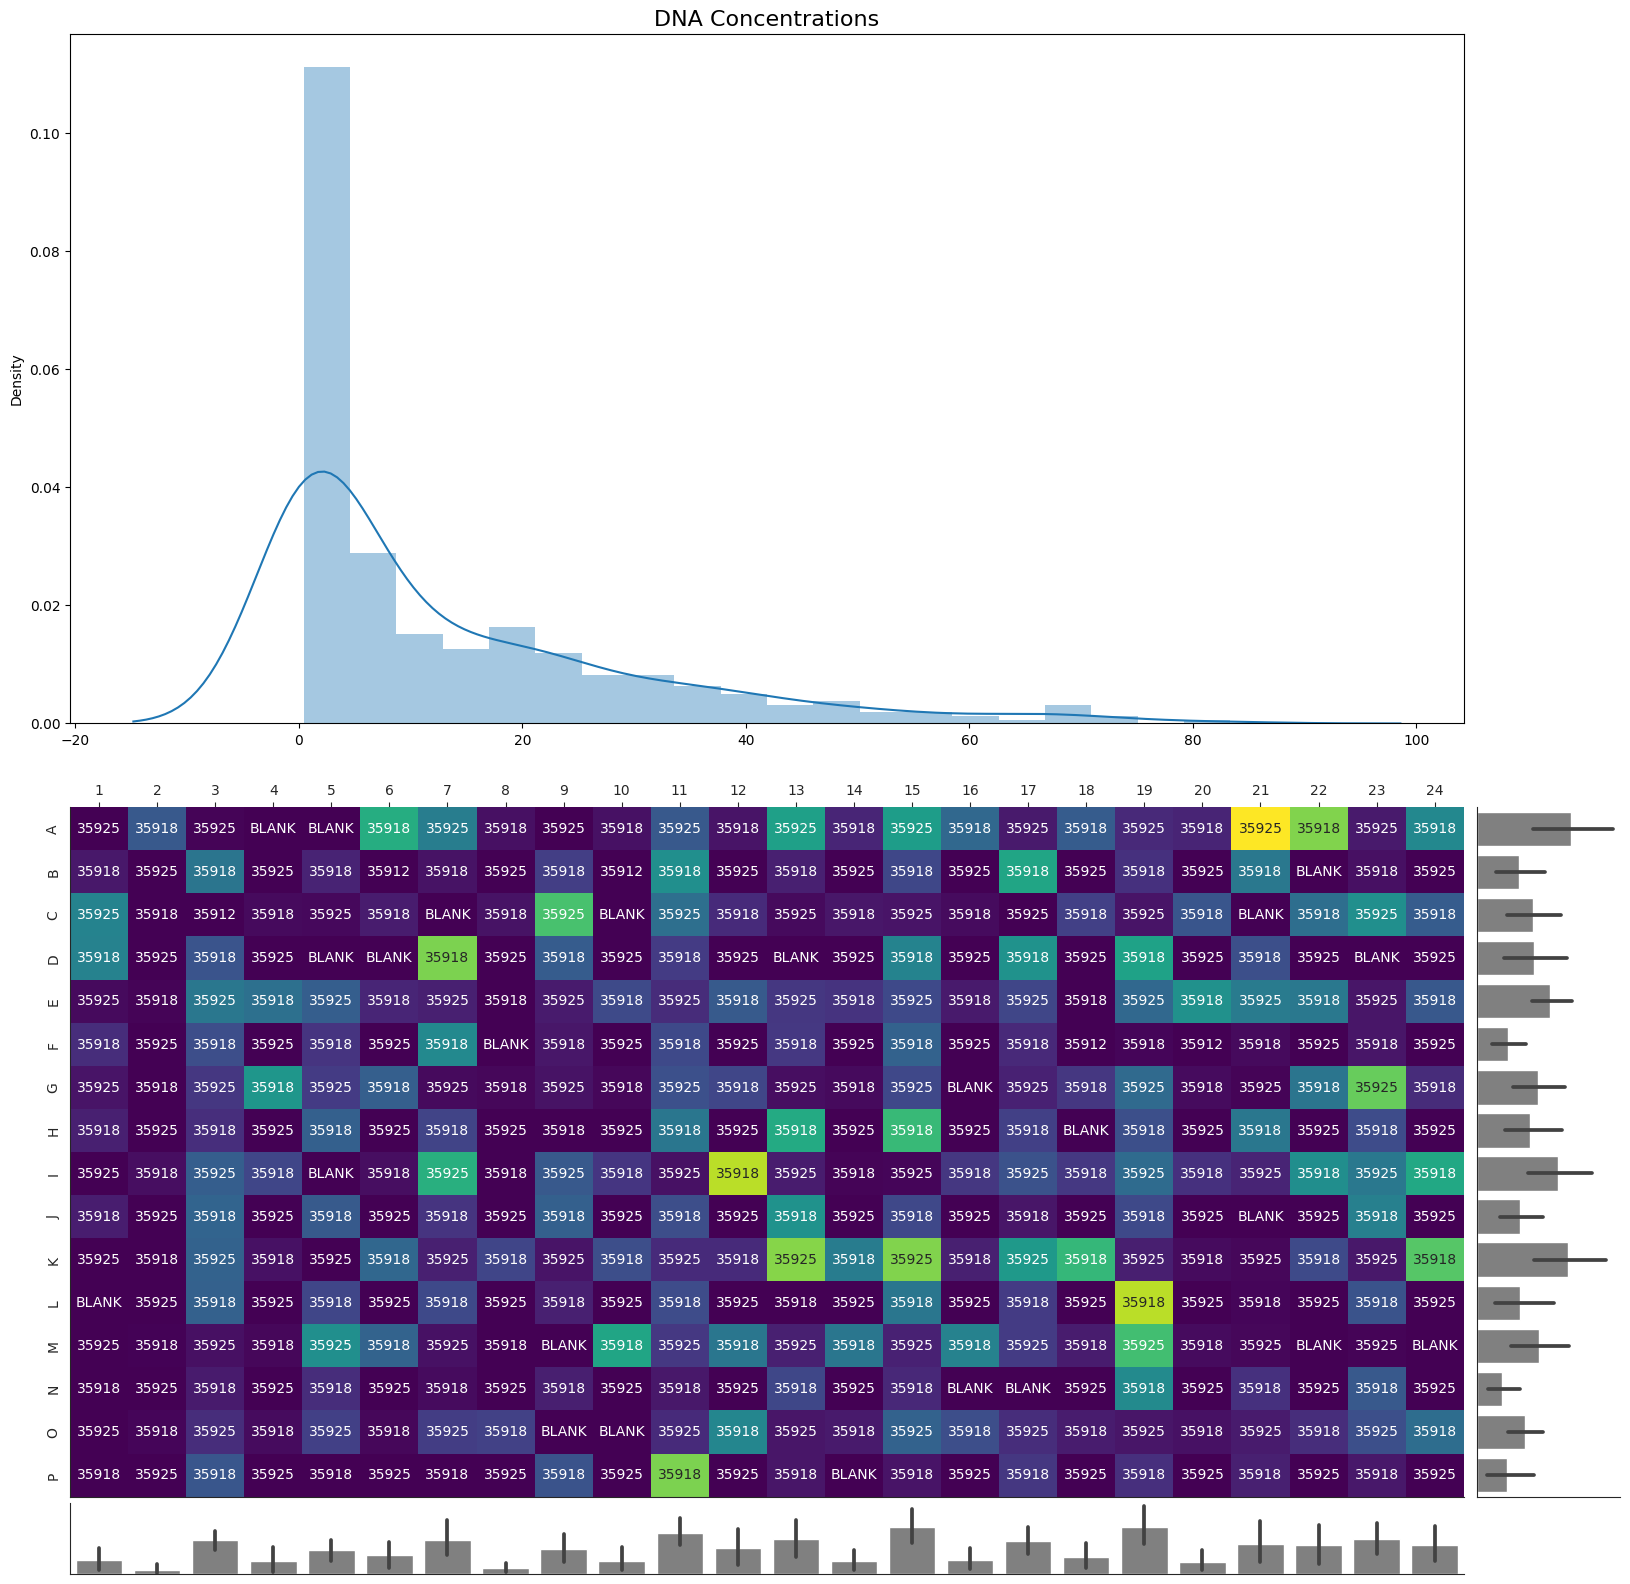

In [67]:
# get DNA & RNA concentratin information
dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)
rna_concs = make_2D_array(plate_df, data_col='Sample RNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)

plot_plate_vals(dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')
plt.title("DNA Concentrations",fontsize=16)

**Visualize plate RNA concentrations and plate map:**

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'RNA Concentrations')

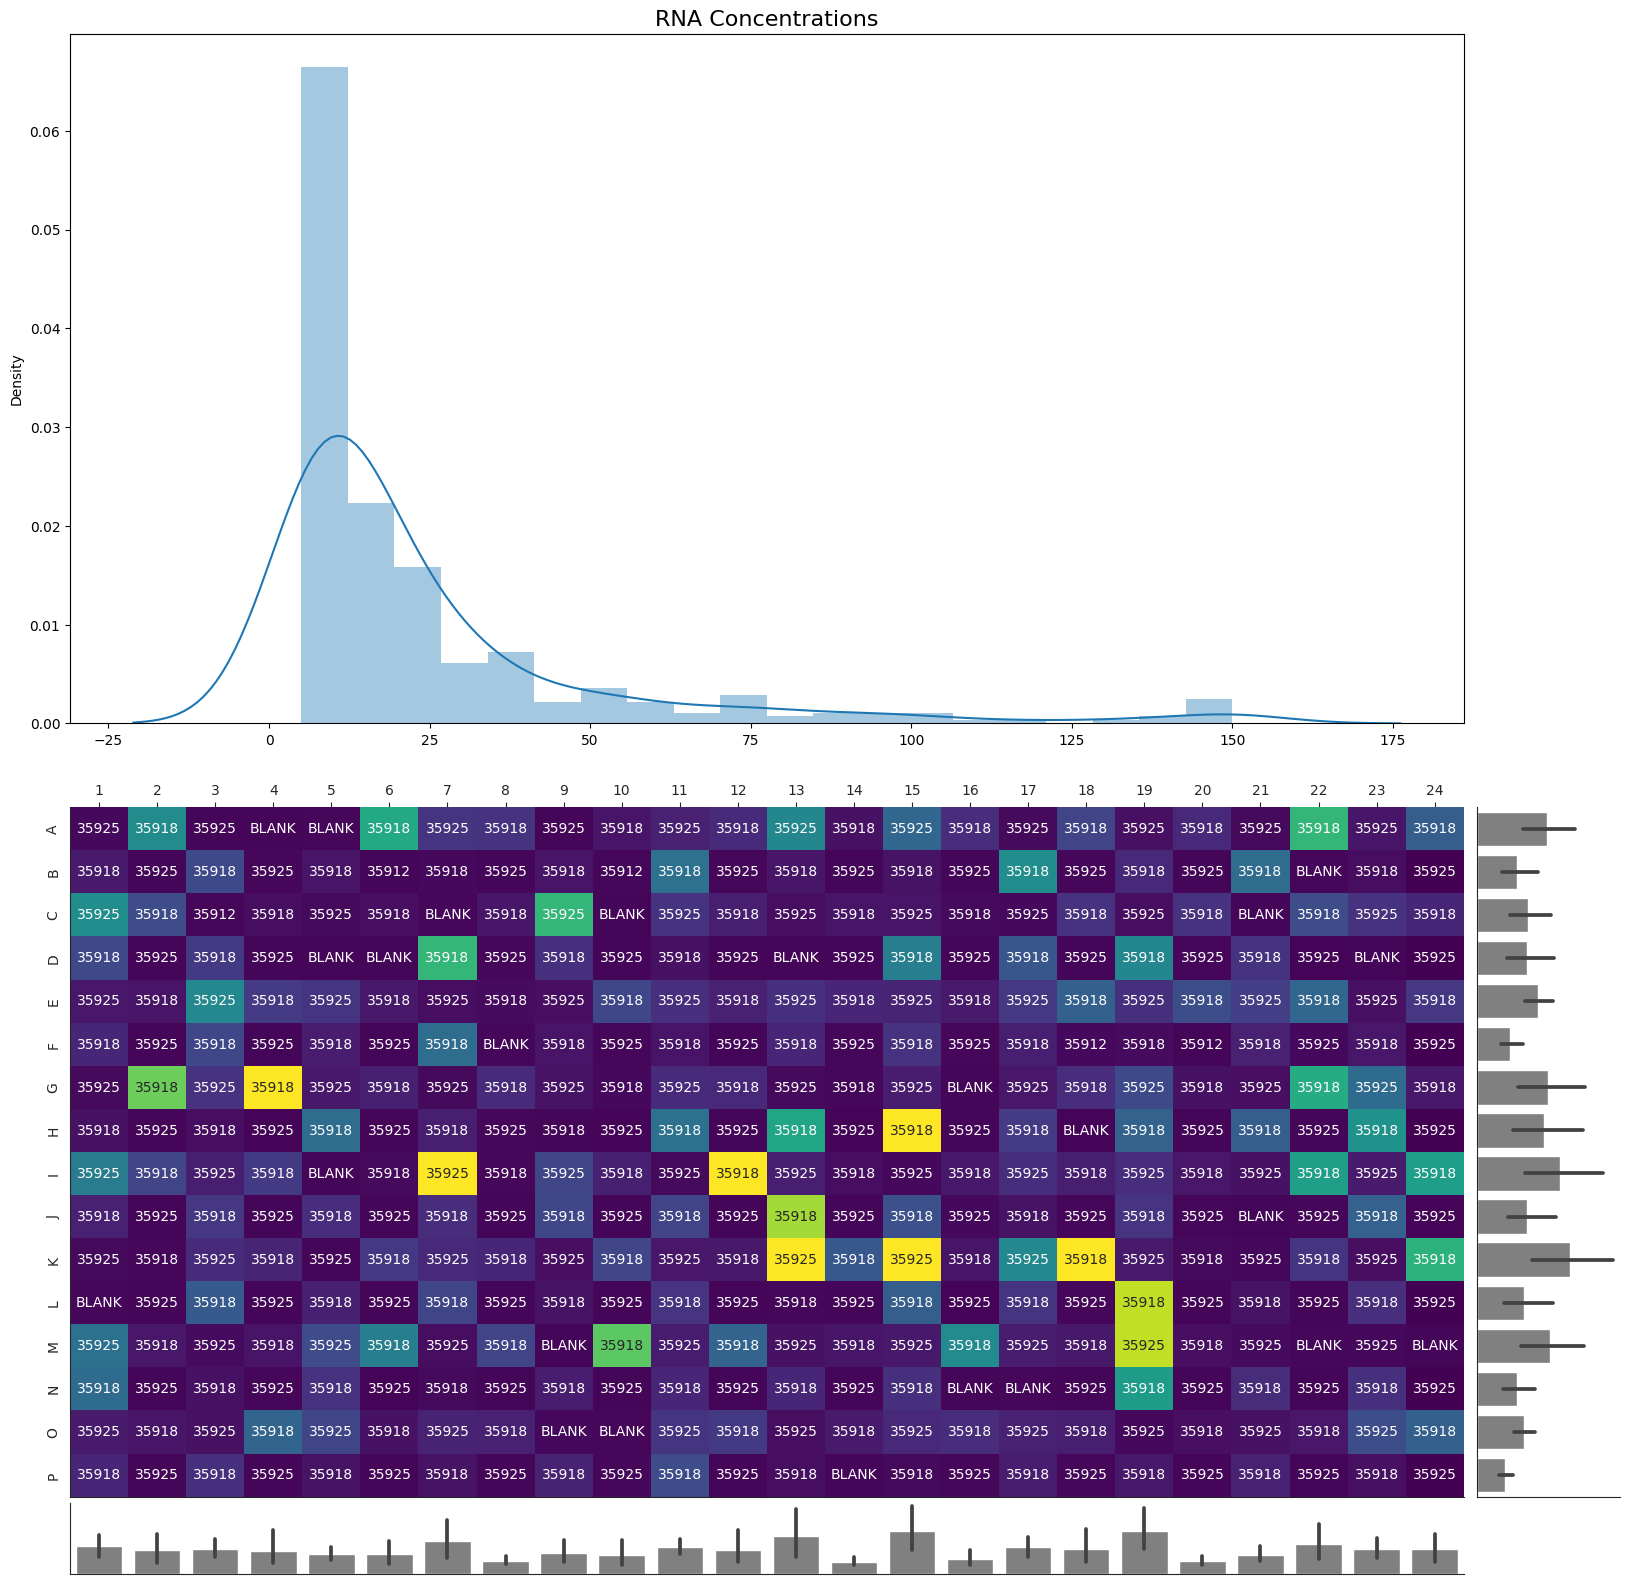

In [68]:
plot_plate_vals(rna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')
plt.title("RNA Concentrations",fontsize=16)

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Project Plate', ylabel='Sample DNA Concentration'>

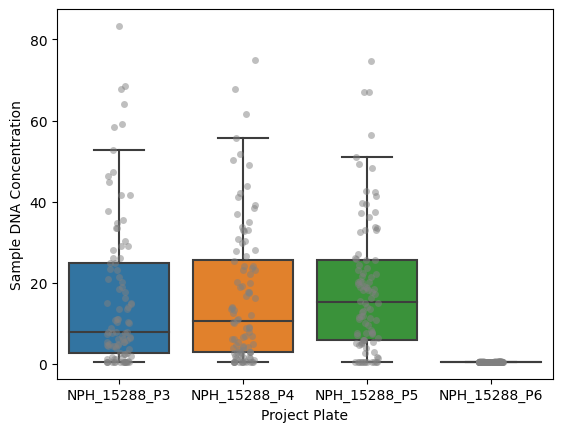

In [69]:
sns.boxplot(x='Project Plate',y='Sample DNA Concentration',data=plate_df,fliersize=0)
sns.stripplot(x='Project Plate',y='Sample DNA Concentration',data=plate_df,color='grey',alpha=0.5)

In [70]:
for plate in plate_df['Project Plate'].unique():
    plate_needs_dilution = requires_dilution(plate_df.loc[plate_df['Project Plate']==plate,
                          ['Sample DNA Concentration']], threshold=40)
    if plate_needs_dilution:
        #Dilution, 1:dilution factor
        #sample : total volume (as a factor)
        for dilution_factor in range(2,6):
            dilute_ = requires_dilution(plate_df.loc[plate_df['Project Plate']==plate,
                              ['Sample DNA Concentration']]/dilution_factor, threshold=40)
            if dilute_:
                continue
            else:
                print(f'You  need to do a a 1:{dilution_factor} dilution for {plate}')
                break
    else:
        print(f'You do not need a dilution for {plate}')

You  need to do a a 1:2 dilution for NPH_15288_P3
You  need to do a a 1:2 dilution for NPH_15288_P4
You  need to do a a 1:2 dilution for NPH_15288_P5
You do not need a dilution for NPH_15288_P6


# Post DNAse QC (Optional but highly encouraged)

In [71]:
dnase_dna_concs_fp = './test_data/Quant/MiniPico/2024_NPH_Plates_3-6_Post_DNase_gDNA_Quant.txt'

if not os.path.isfile(sample_dna_concs_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the DNA concentration output file**. It should be a .txt file and should look something like this:
    
```
##BLOCKS= 1
Group: Unknowns
Sample	Wells	RFU_Values	Concentration	Mean_Conc	SD	CV	Dilution	AdjConc	
01	A1	16352.000	0.434	0.434	0.000	0.0			
02	C1	26061758.000	37.588	37.588	0.000	0.0			
03	E1	1483519.000	2.527	2.527	0.000	0.0			
04	G1	3015184.000	4.712	4.712	0.000	0.0			
05	I1	16574.000	0.434	0.434	0.000	0.0			
06	K1	14988.000	0.432	0.432	0.000	0.0			
```

In [72]:
dnase_dna_concs = read_pico_csv(dnase_dna_concs_fp, plate_reader='SpectraMax_i3x',conc_col_name='Post DNAse DNA Concentration')

plate_df = pd.merge(plate_df, dnase_dna_concs, on='Well')

well_col = 'Well'

plate_df.head()

Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  Sample DNA Concentration  \
0         A1                      Q1   A1                     0.434   
1         B1                      Q1   C1                    37.588   
2         C1                      Q1   E1                     2.527   
3         D1                      Q1   G1                     4.712   
4         E1                      Q1   I1                     0.434   

   Sample RNA Concentration  Post DNAse DNA Concentration  
0                     8.353                         0.582  
1                    75.672                         1.025  
2                    13.753                         0.627  
3                     8.874                         0.600  
4                    64.974                         1.217

**Enter the correct path to the Pico RNA concentration output**. This should be a txt-formatted file produced by the MiniPico assay on the condensed, 384-well plate. 

In [73]:
dnase_rna_concs_fp = './test_data/Quant/MiniPico/2024_NPH_Plates_3-6_Post_DNase_RNA_Quant.txt'

if not os.path.isfile(dnase_rna_concs_fp):
    print("Problem! %s is not a path to a valid file" % file)

In [74]:
dnase_rna_concs = read_pico_csv(dnase_rna_concs_fp, plate_reader='SpectraMax_i3x',conc_col_name='Post DNAse RNA Concentration')

plate_df = pd.merge(plate_df, dnase_rna_concs, on='Well')

well_col = 'Well'

plate_df.head()

Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  Sample DNA Concentration  \
0         A1                      Q1   A1                     0.434   
1         B1                      Q1   C1                    37.588   
2         C1                      Q1   E1                     2.527   
3         D1                      Q1   G1                     4.712   
4         E1                      Q1   I1                     0.434   

   Sample RNA Concentration  Post DNAse DNA Concentration  \
0                     8.353                         0.582   
1                    75.672                         1.025   
2                    13.753                         0.627   
3                     8.874                         0.600   
4                    64.974                         1.217   

   Post DNAse RNA Concentration  
0                         3.469  
1                        25.797  
2                         8.345  
3                         3.846  
4                        33.047

**Visualize plate DNA/RNA concentrations after DNAse treatment:**

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Post-DNAse DNA Concentrations')

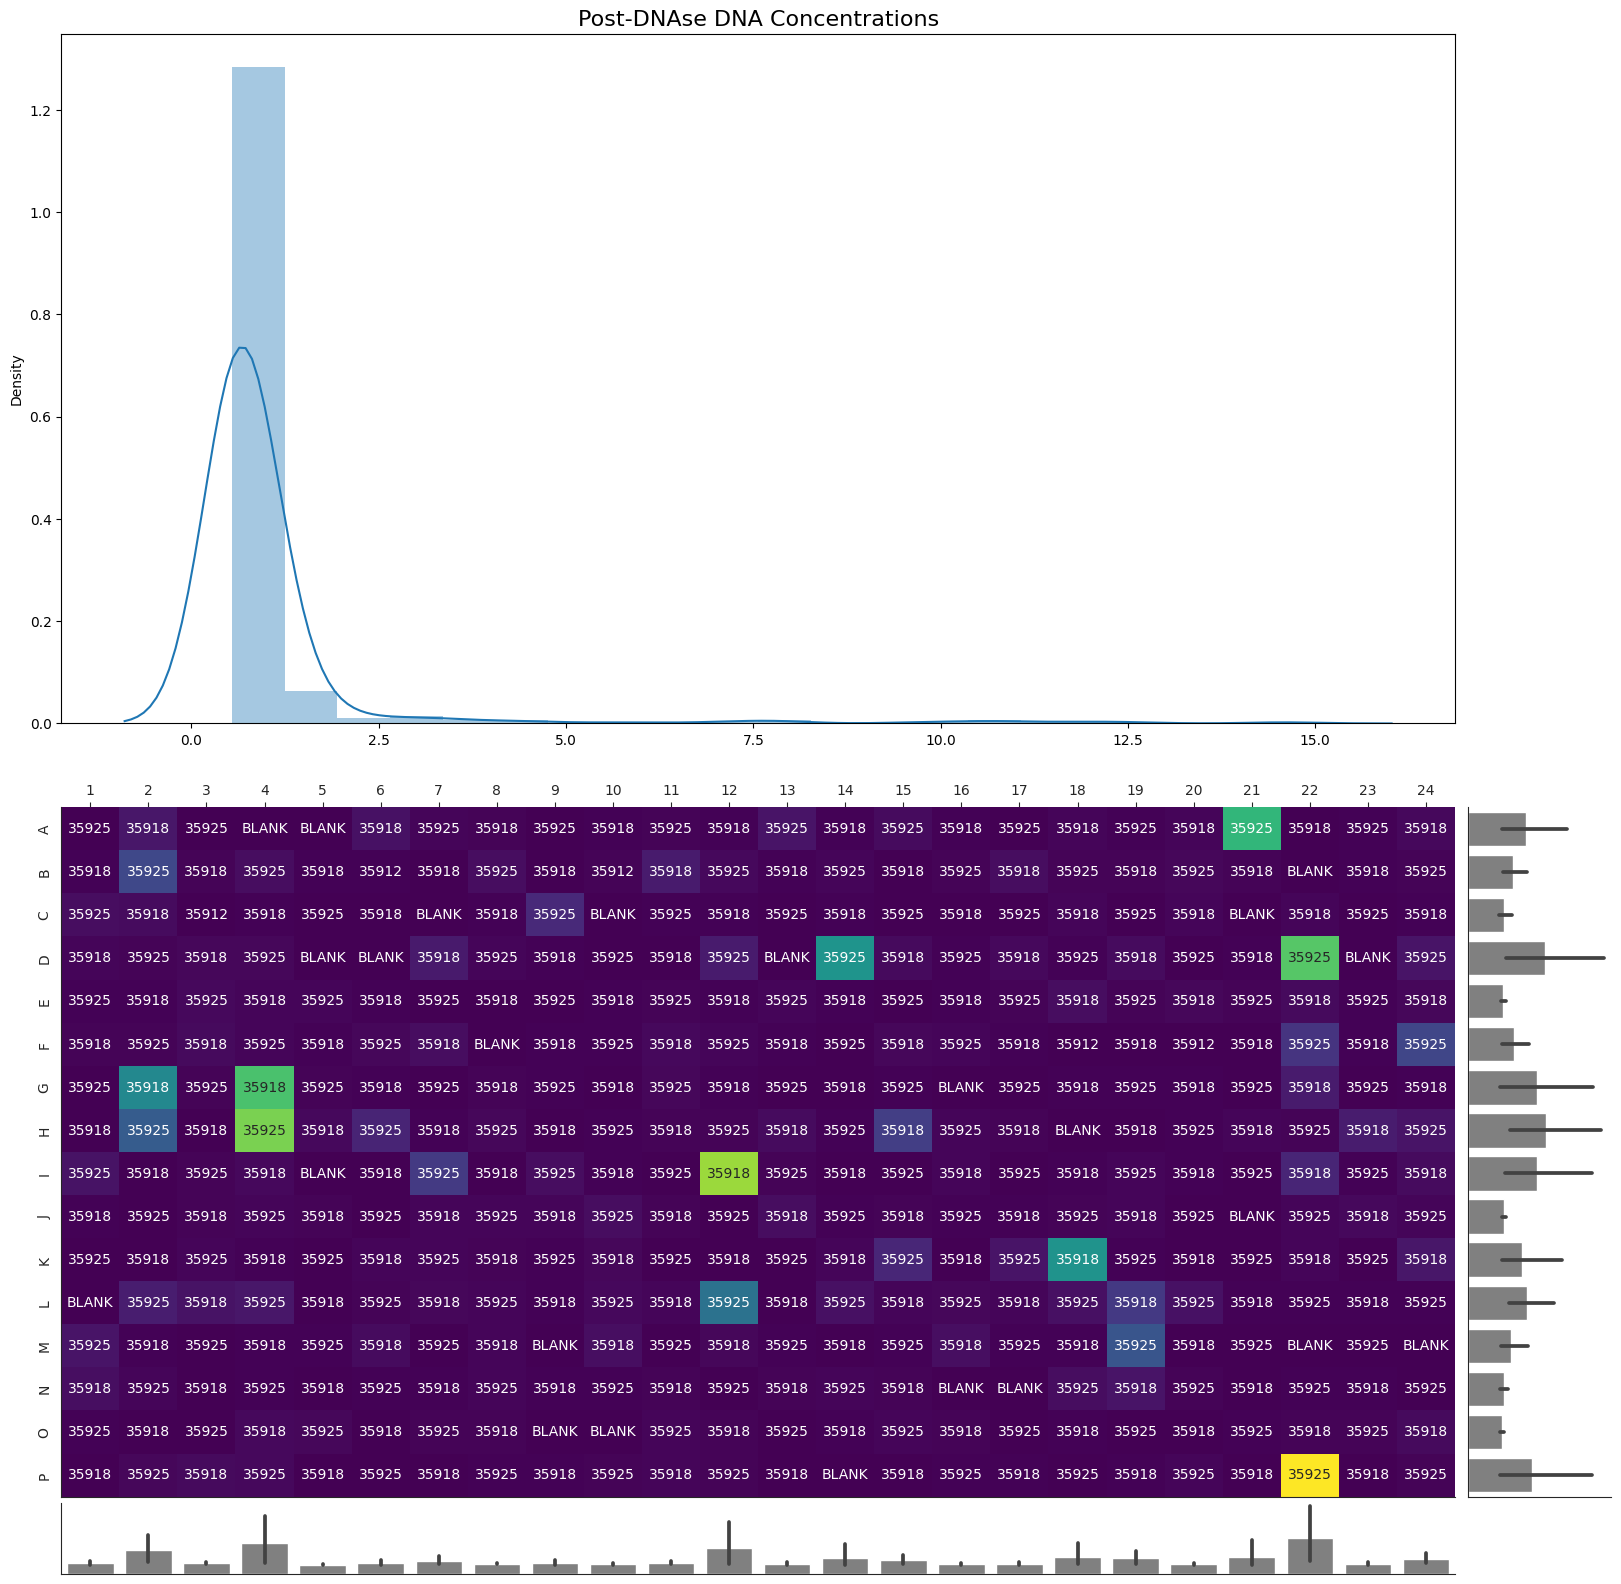

In [75]:
# get DNA & RNA post DNAse information
dna_dnase = make_2D_array(plate_df, data_col='Post DNAse DNA Concentration', well_col=well_col).astype(float)
rna_dnase = make_2D_array(plate_df, data_col='Post DNAse RNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)

plot_plate_vals(dna_dnase,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')
plt.title("Post-DNAse DNA Concentrations",fontsize=16)

**Visualize plate RNA concentrations and plate map:**

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Post-DNAse RNA Concentrations')

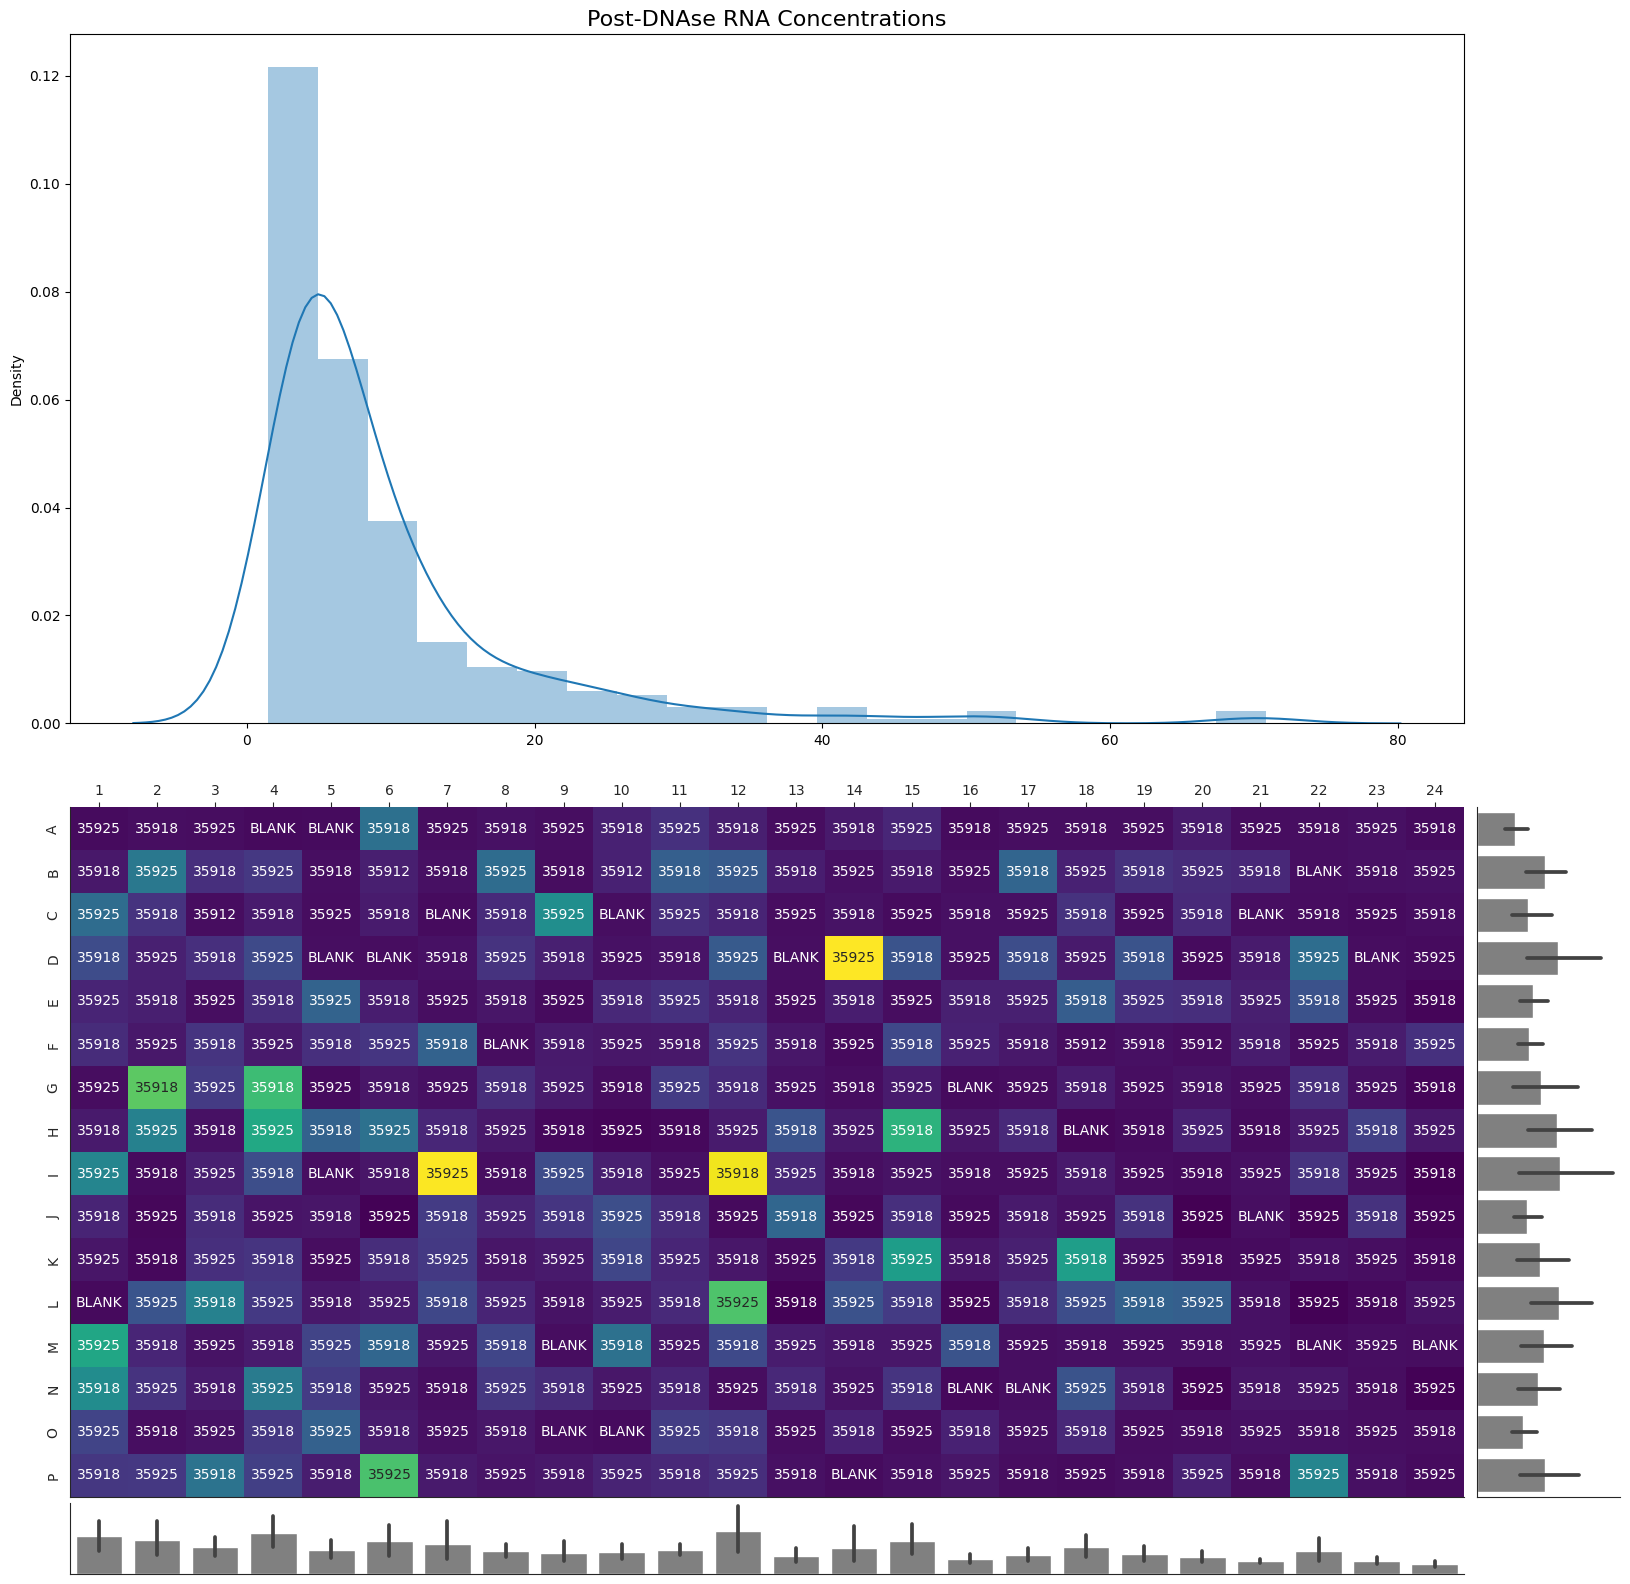

In [76]:
plot_plate_vals(rna_dnase,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')
plt.title("Post-DNAse RNA Concentrations",fontsize=16)

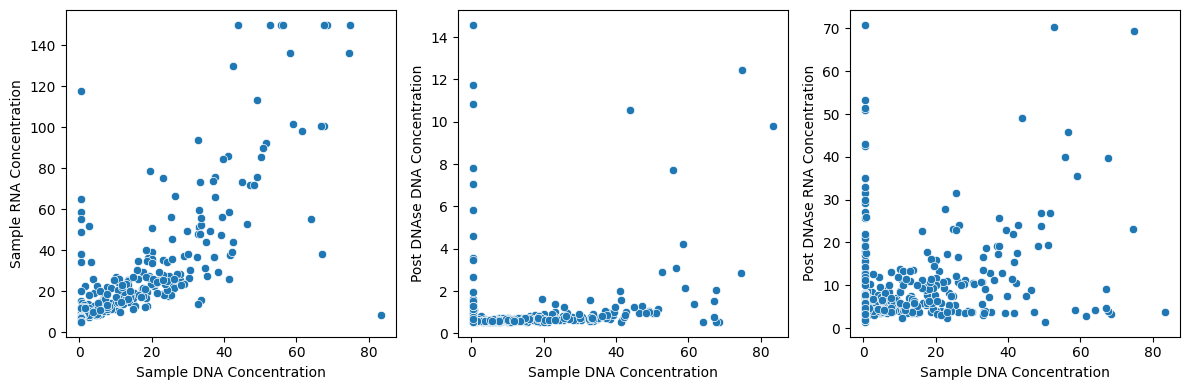

In [77]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(12,4))
sns.scatterplot(x='Sample DNA Concentration',y='Sample RNA Concentration',data=plate_df,ax=ax1)
sns.scatterplot(x='Sample DNA Concentration',y='Post DNAse DNA Concentration',data=plate_df,ax=ax2)
sns.scatterplot(x='Sample DNA Concentration',y='Post DNAse RNA Concentration',data=plate_df,ax=ax3)
plt.tight_layout()

### Make sample replicates

In [78]:
# Examples of replicates

# replicate_dict = {source1_quadrant:destination1_quadrant}
# replicate_dict = {source1_quadrant:[destination1_quadrants,destination1_quadrants]}

#replicate_dict = {1:[2,3]}

# initialize a new PlateReplication object to manage metadata, conversions, and more for you.
# initialize w/preferred well_col.
well_col = 'Library Well'
pr = PlateReplication(well_col)

# set overwrite=False to detect any overwriting of source or destination quads and raise an Error.
# replace replicates = None with replicates = replicate_dict to make replicates
plate_df = pr.make_replicates(plate_df, replicates=None, overwrite=True)

#replicates overlapping sample_wells for other samples shuld raise warning, but will be allowed
if 'True' in plate_df['contains_replicates'].unique():
    plate_df['contains_replicates'] = True
    # get DNA concentratin information
    dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

    # get information for annotation
    names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)

    plot_plate_vals(dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.6s')
else:
    plate_df['contains_replicates'] = False

In [79]:
# Make mask arrays for even and odd rows and columns

even_rows = [x for x in range(16) if x % 2 == 0]
odd_rows = [x for x in range(16) if x % 2 == 1]
even_cols = [x for x in range(24) if x % 2 == 0]
odd_cols = [x for x in range(24) if x % 2 == 1]

### gDNA concentration heatmap, Plate 1

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


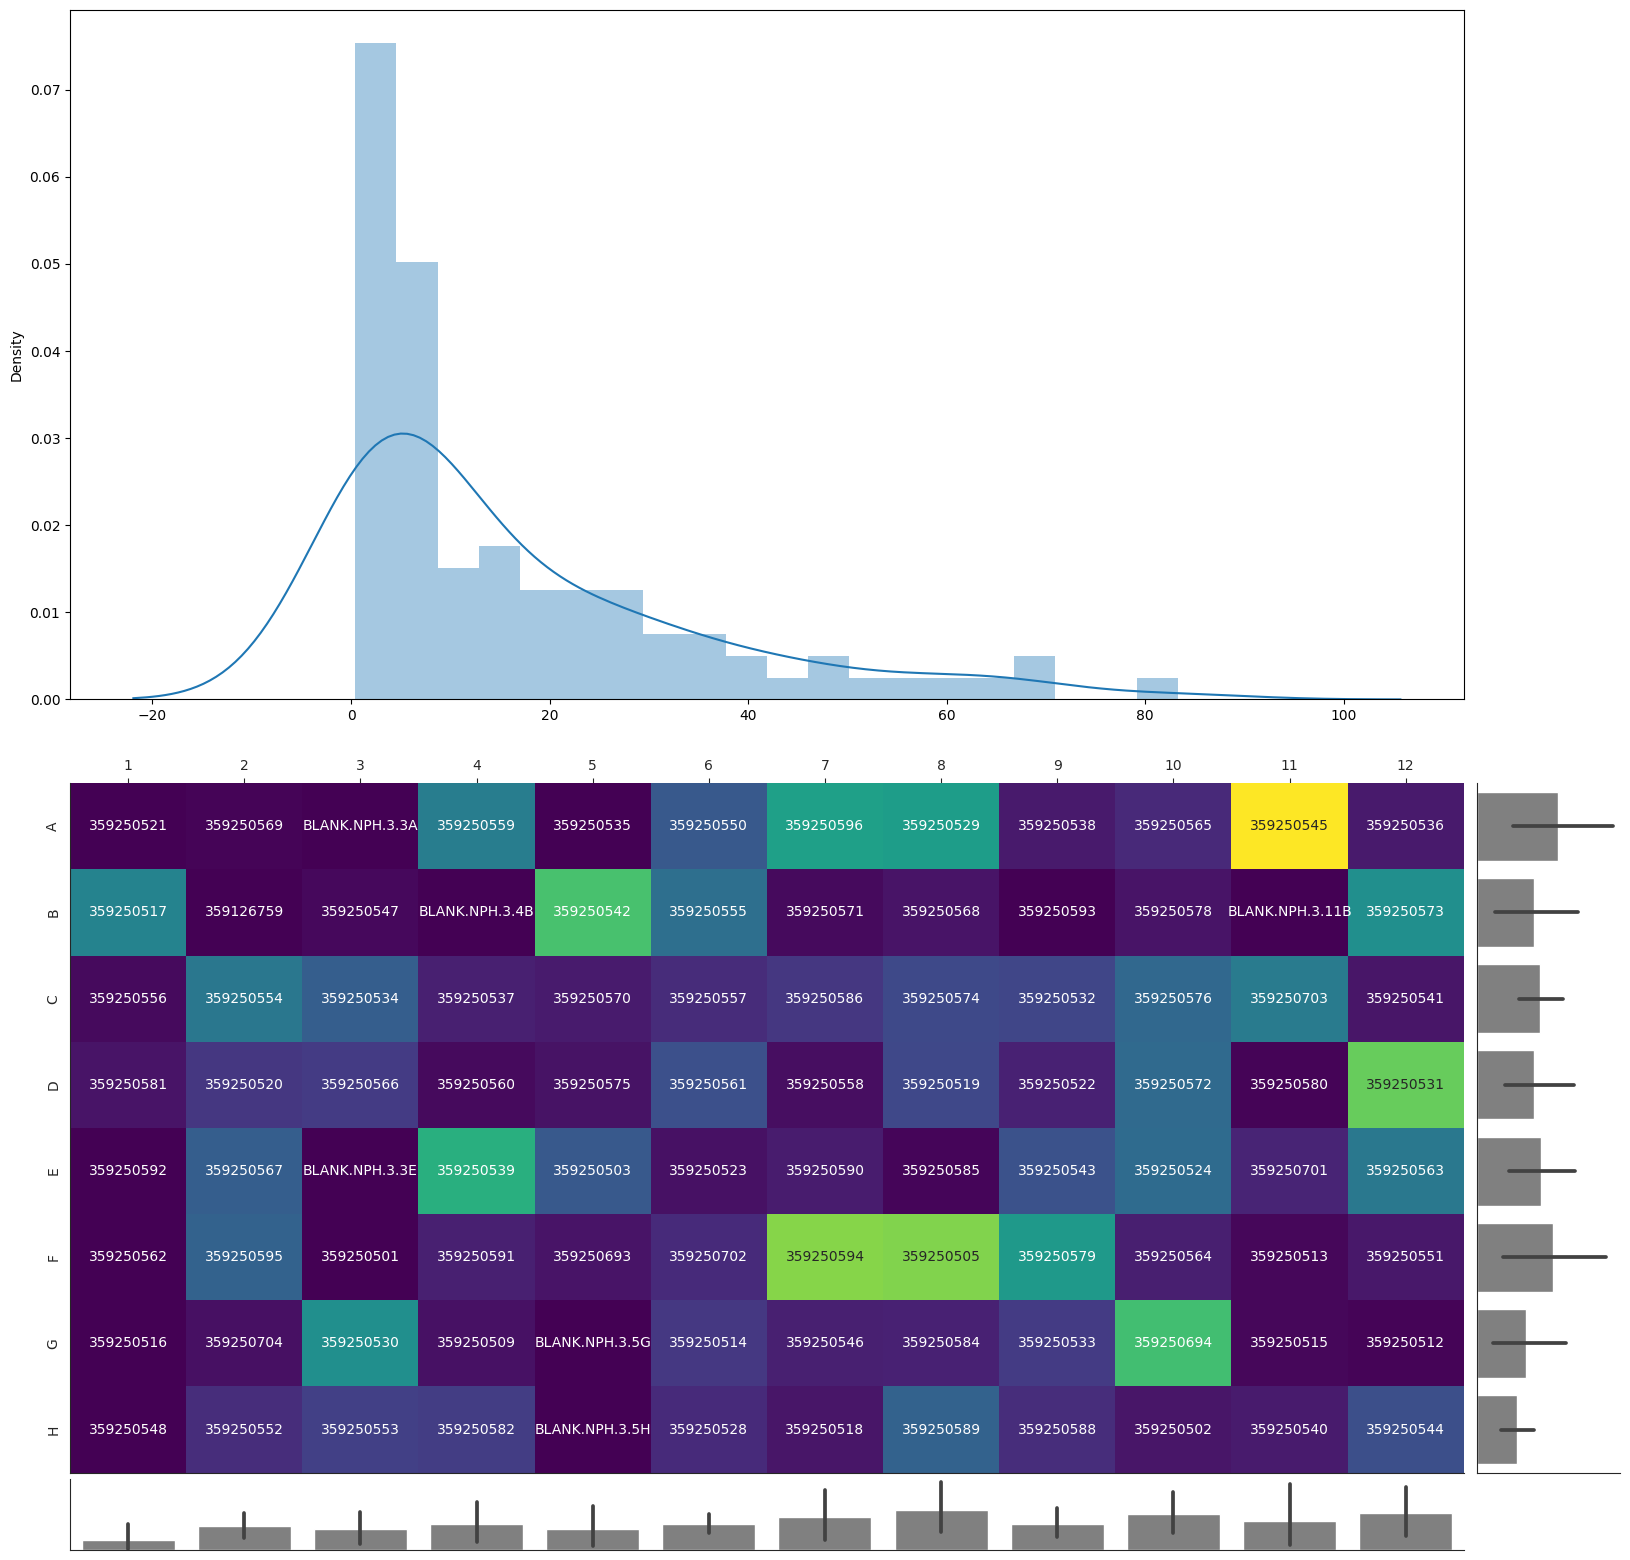

In [80]:
plot_plate_vals(dna_concs[np.ix_(even_rows,even_cols)],
                annot_str= names[np.ix_(even_rows,even_cols)],
                color_map='viridis',
                annot_fmt='')

### gDNA concentration heatmap, Plate 2

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


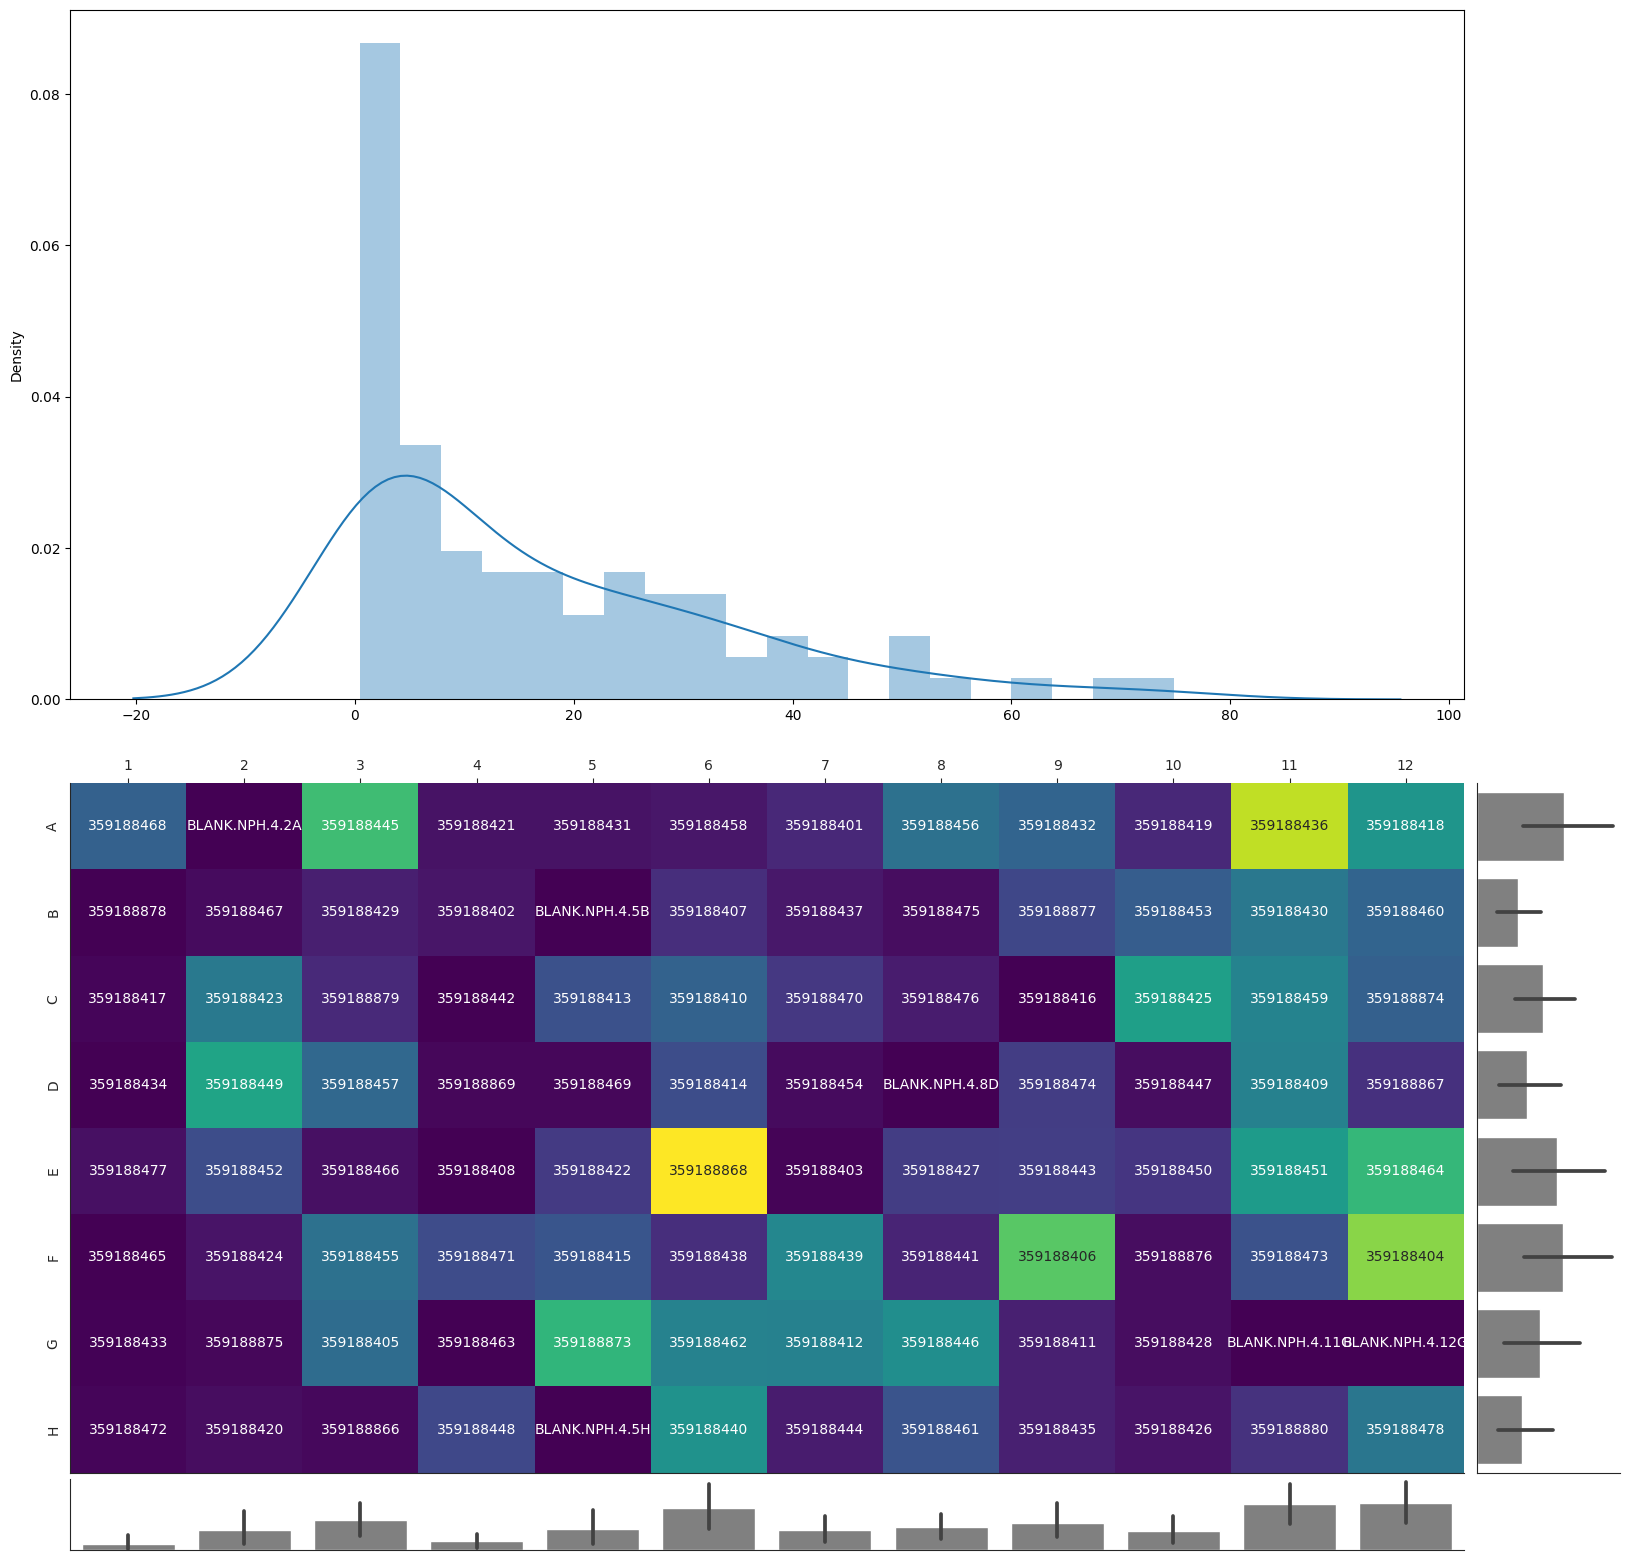

In [81]:
plot_plate_vals(dna_concs[np.ix_(even_rows,odd_cols)],
                    annot_str= names[np.ix_(even_rows,odd_cols)],
                    color_map='viridis',
                    annot_fmt='')

### gDNA concentration heatmap, Plate 3

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


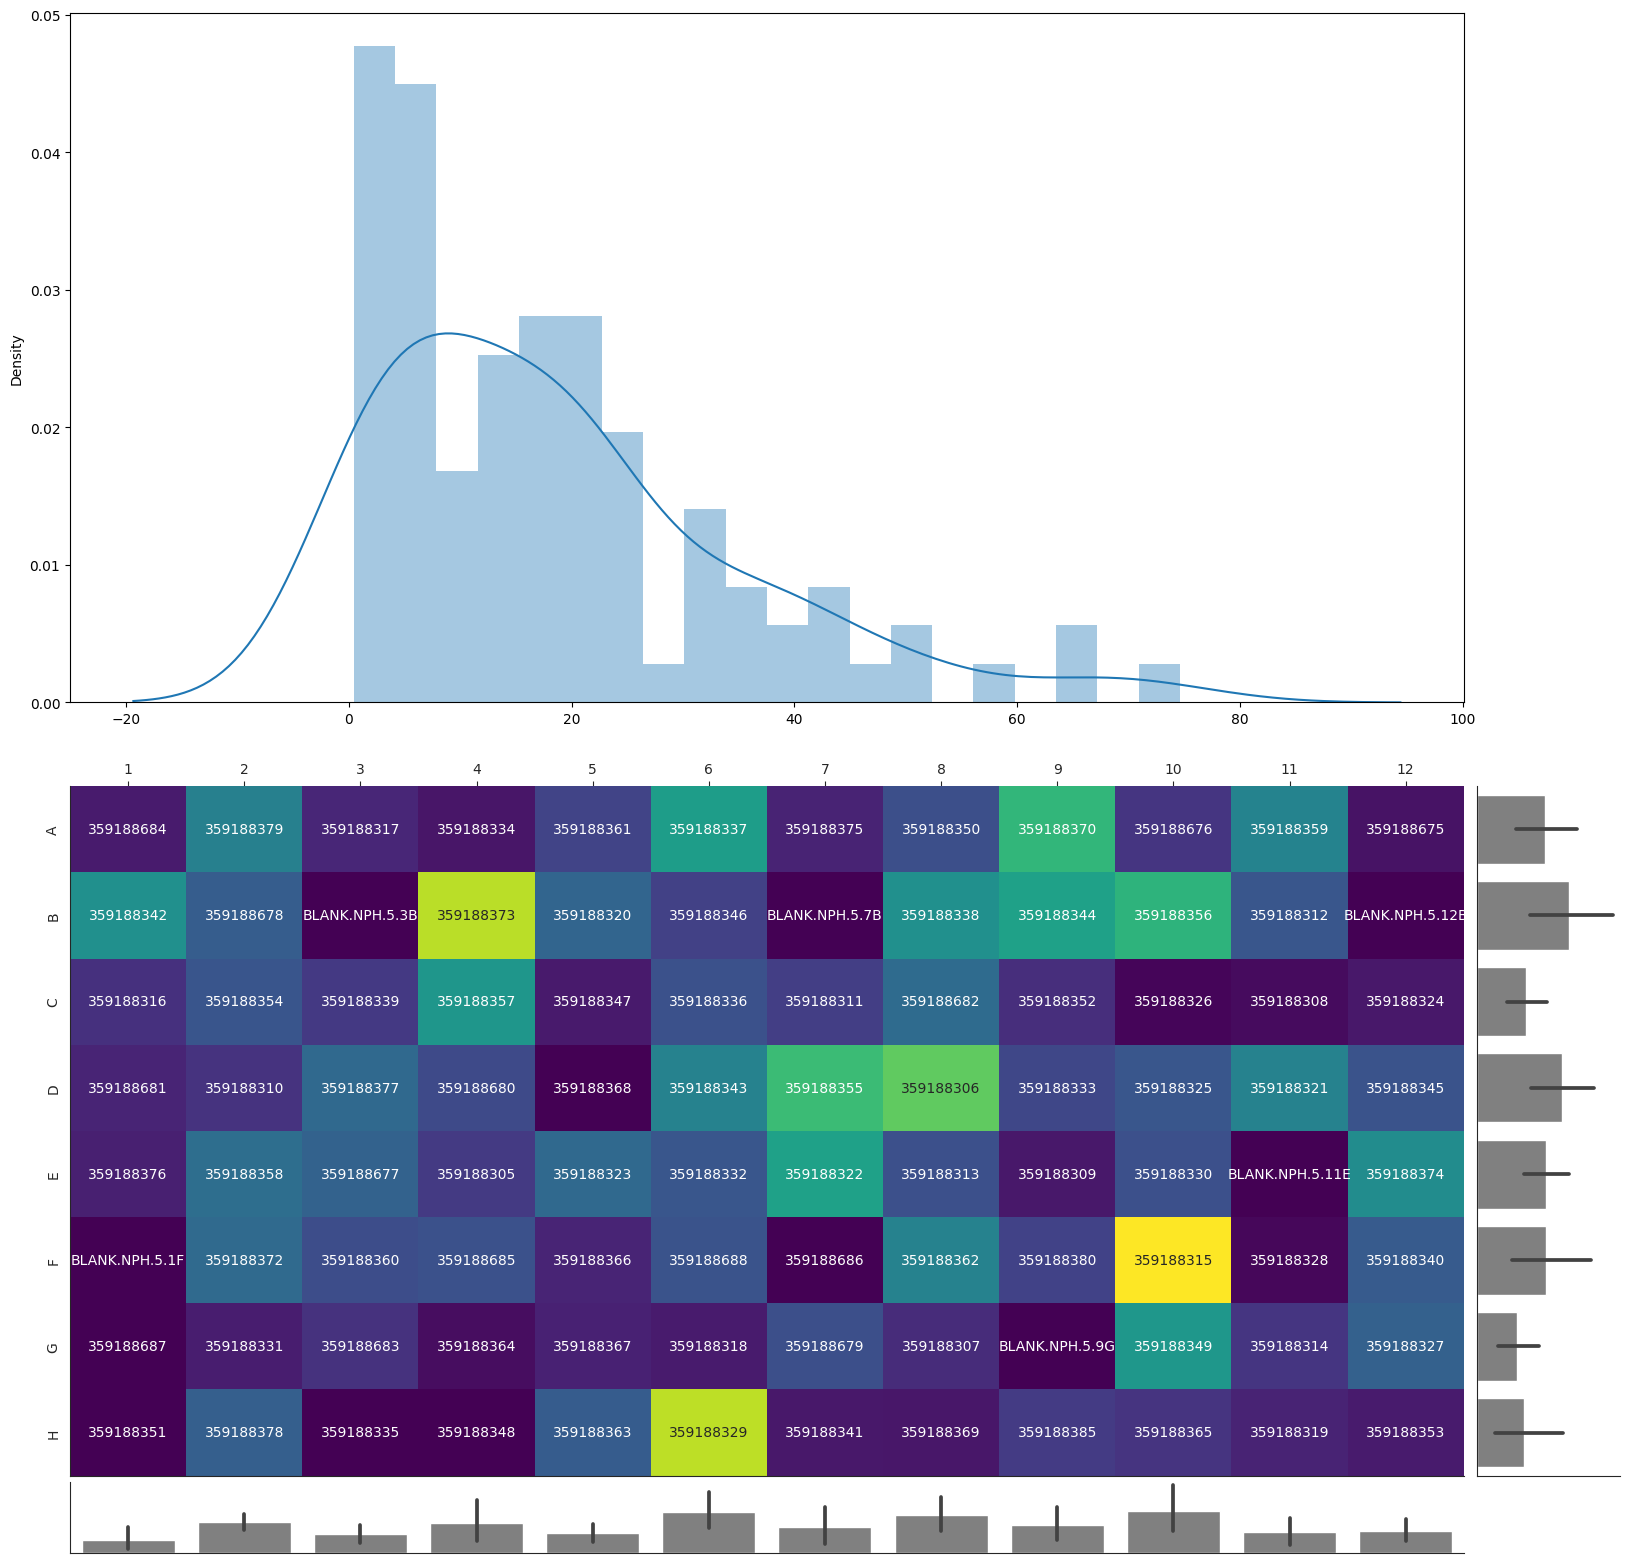

In [82]:
plot_plate_vals(dna_concs[np.ix_(odd_rows,even_cols)],
                    annot_str= names[np.ix_(odd_rows,even_cols)],
                    color_map='viridis',
                    annot_fmt='')

### gDNA concentration heatmap, Plate 4

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


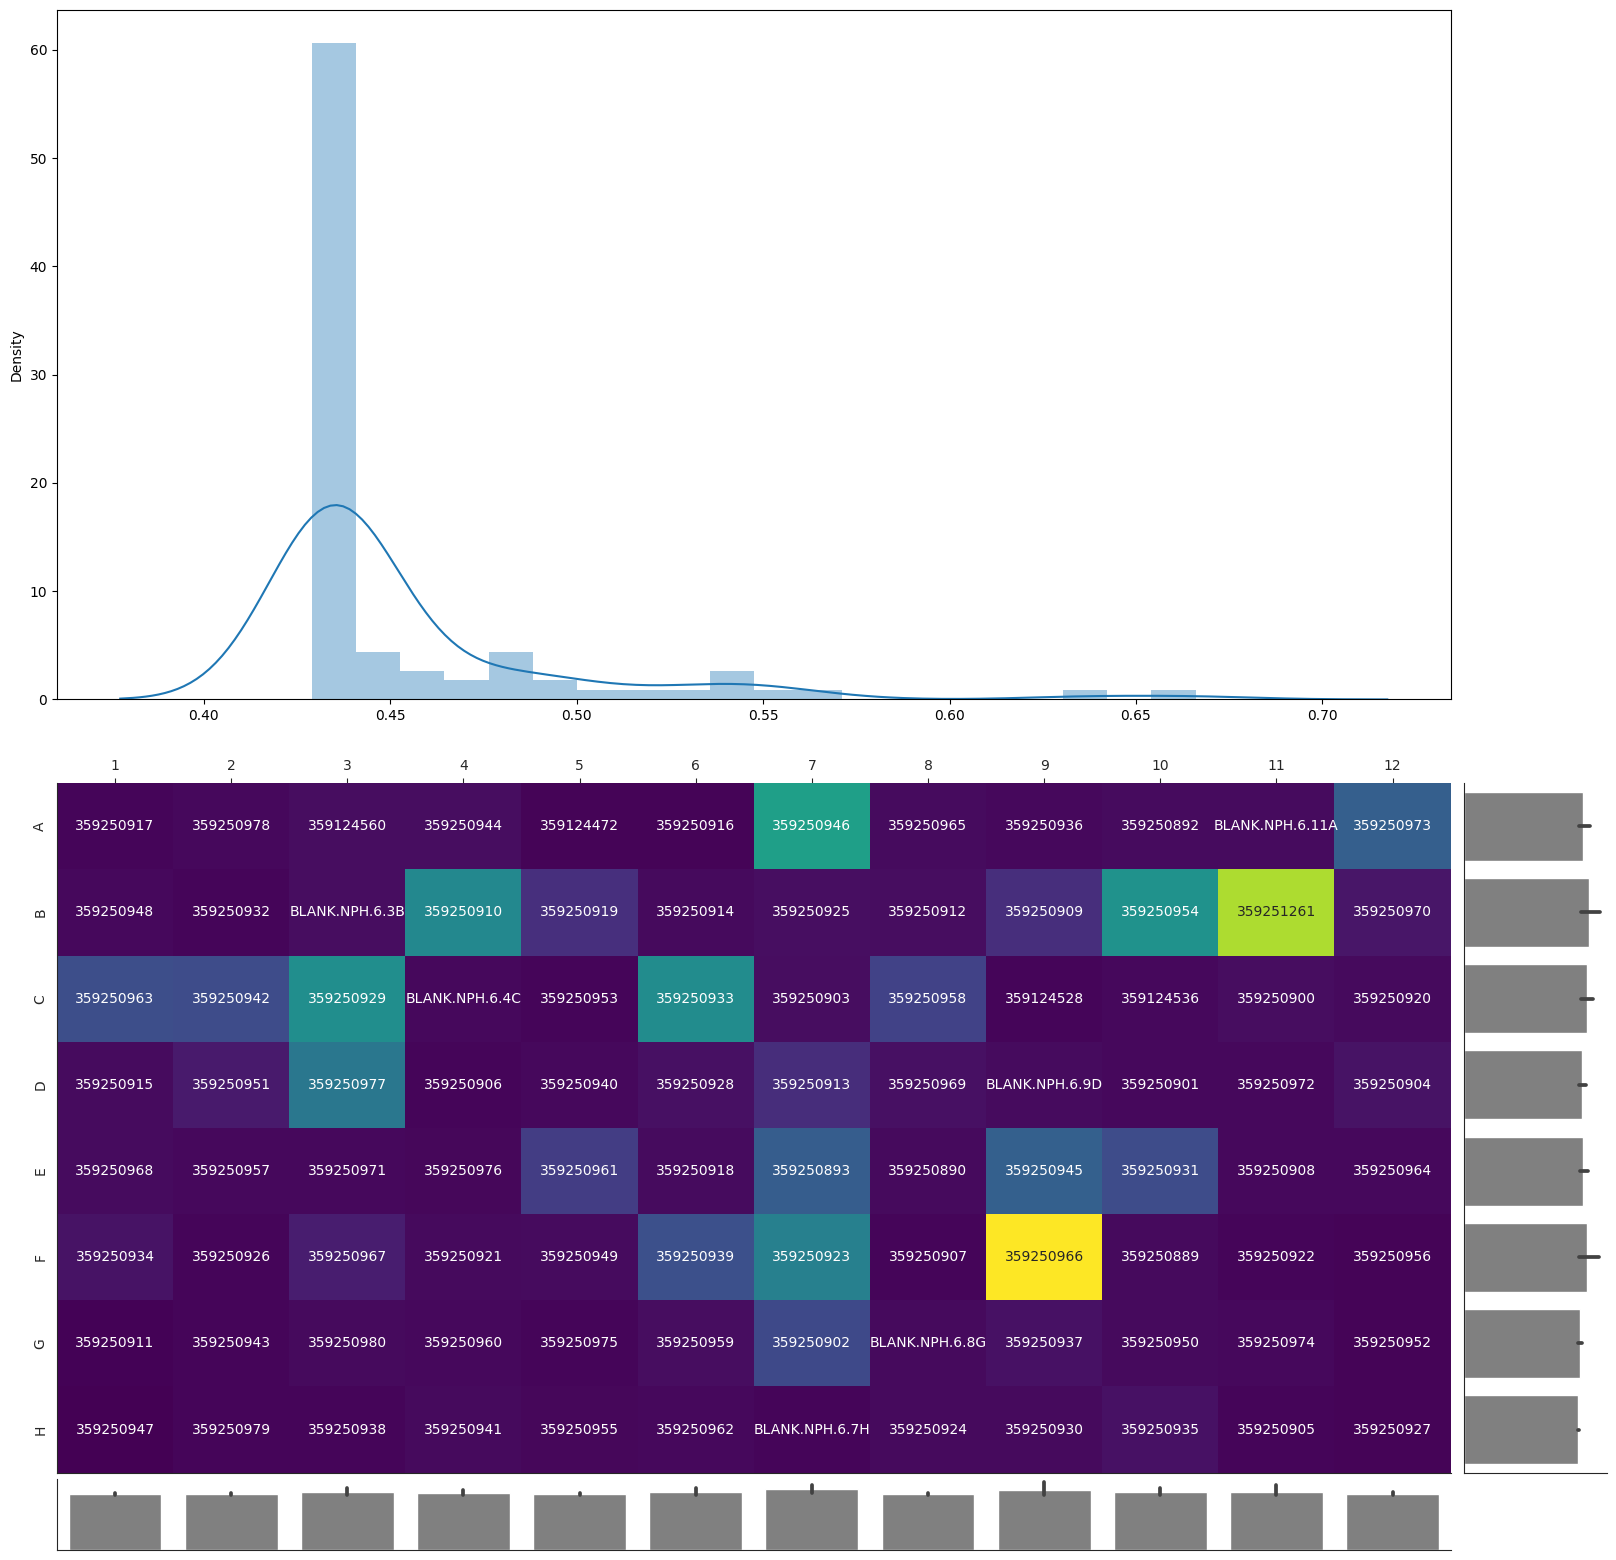

In [83]:
plot_plate_vals(dna_concs[np.ix_(odd_rows,odd_cols)],
                    annot_str= names[np.ix_(odd_rows,odd_cols)],
                    color_map='viridis',
                    annot_fmt='')

# Workflow for assigning barcodes

This portion of the notebook will assign index values and construct an Echo picklist file for adding barcodes. 

As inputs, it requires:
1. A plate map dataframe (from previous step)
2. A tab-delimited index combination file, relating index combinations, i5 and i7 index values, and i5 and i7 index locations

The workflow then:
1. reads in the index combo list
2. assigns indices per sample
3. produces an Echo-formatted pick list file

## Step 1: Read in index combo list

This is a file that contains every possible i5 and i7 barcode combo on a separate line,
along with plate and well location information. It should look something like this:

```
index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate
1,AGTGGCAACTGTGTTG,iTru5_01_B,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate
2,CACAGACTTGAGGTGT,iTru5_01_C,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate
3,CGACACTTGATCCATG,iTru5_01_D,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate
4,GACTTGTGGCCTATCA,iTru5_01_E,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate
5,GTGAGACTAACAACCG,iTru5_01_F,GTGAGACT,F1,iTru5_plate,iTru7_101_06,AACAACCG,A6,iTru7_plate
6,GTTCCATGACTCGTTG,iTru5_01_G,GTTCCATG,G1,iTru5_plate,iTru7_101_07,ACTCGTTG,A7,iTru7_plate
7,TAGCTGAGCCTATGGT,iTru5_01_H,TAGCTGAG,H1,iTru5_plate,iTru7_101_08,CCTATGGT,A8,iTru7_plate
8,CTTCGCAATGTACACC,iTru5_02_A,CTTCGCAA,I1,iTru5_plate,iTru7_101_09,TGTACACC,A9,iTru7_plate
```

In [84]:
index_combo_fp = './test_output/iTru/new_iTru_combos_Dec2017.csv'

if not os.path.isfile(index_combo_fp):
    print("Problem! %s is not a path to a valid file" % file)

In [85]:
index_combos = pd.read_csv(index_combo_fp)
index_combos.head()

index combo   index combo seq     i5 name i5 sequence i5 well     i5 plate  \
0            0  ACCGACAAACGTTACC  iTru5_01_A    ACCGACAA      A1  iTru5_plate   
1            1  CTTCGCAACTGTGTTG  iTru5_02_A    CTTCGCAA      A3  iTru5_plate   
2            2  AACACCACTGAGGTGT  iTru5_03_A    AACACCAC      A5  iTru5_plate   
3            3  CGTATCTCGATCCATG  iTru5_04_A    CGTATCTC      A7  iTru5_plate   
4            4  GGTACGAAGCCTATCA  iTru5_05_A    GGTACGAA      A9  iTru5_plate   

        i7 name i7 sequence i7 well     i7 plate  
0  iTru7_101_01    ACGTTACC      A1  iTru7_plate  
1  iTru7_101_02    CTGTGTTG      A3  iTru7_plate  
2  iTru7_101_03    TGAGGTGT      A5  iTru7_plate  
3  iTru7_101_04    GATCCATG      A7  iTru7_plate  
4  iTru7_101_05    GCCTATCA      A9  iTru7_plate

## Step 2: Assign index combo

This will pick a set of index combos from the index combo for the number of samples in the `plate_df` DataFrame.

Keep track of the barcode combinations used in the lab, and set `starting_combo` equal to the next unused combination.

One of way of doing that might be to keep track of the number of plates run, and set `starting_combo` equal to
384 * number of plates run + 1.

In [86]:
plate_counter = 240

starting_combo = ((plate_counter - 1) % 384) * 384

indices = assign_index(len(plate_df['Sample']), index_combos, start_idx=starting_combo).reset_index()

plate_df = pd.concat([plate_df, indices], axis=1)

plate_df.head()

Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  ...  index combo   index combo seq  \
0         A1                      Q1   A1  ...        91776  ACCGACAAATGCCAAC   
1         B1                      Q1   C1  ...        91777  CTTCGCAACACGTTGT   
2         C1                      Q1   E1  ...        91778  AACACCACTATTCCGG   
3         D1                      Q1   G1  ...        91779  CGTATCTCTGCTTCCA   
4         E1                      Q1   I1  ...        91780  GGTACGAAGTCTAGGT   

      i5 name  i5 sequence i5 well     i5 plate       i7 name  i7 sequence  \
0  iTru5_01_A     ACCGACAA      A1  iTru5_plate  iTru7_206_12     ATGCCAAC   
1  iTru5_02_A     CTTCGCAA      A3  iTru5_plate  iTru7_207_01     CACGTTGT   
2  iTru5_03_A     AACACCAC      A5  iTru5_plate  iTru7_207_02     TATTCCGG   
3  iTru5_04_A     CGTATCTC      A7  iTru5_plate  iTru7_207_03     TGCTTCCA   
4  iTru5_05_A     GGTACGAA      A9  iTru5_plate  iTru7_207_04     GTCTAGGT   

  i7 well     i7 plate  
0     H23  iTru7_plate  
1      J1  iTru7_plate  
2      J3  iTru7_plate  
3      J5  iTru7_plate  
4      J7  iTru7_plate  

[5 rows x 27 columns]

## Step 3: Make index pick list

Format the Echo-compatible pick list.

In [87]:
index_picklist = format_index_picklist(plate_df['Sample'], plate_df[well_col], indices)

## Step 4: write pick list to file

In [88]:
# Write the picklist as .txt
index_picklist_fp = './test_output/Indices/YYYY_MM_DD_NPH_3-6_indices_240.txt'

if os.path.isfile(index_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [89]:
with open(index_picklist_fp, 'w') as f:
    f.write(index_picklist)

!head {index_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Transfer Volume	Index Name	Index Sequence	Index Combo	Destination Plate Name	Destination Well
359250521	iTru5_plate	384LDV_AQ_B2	A1	250	iTru5_01_A	ACCGACAA	91776	IndexPCRPlate	A1
359250517	iTru5_plate	384LDV_AQ_B2	A3	250	iTru5_02_A	CTTCGCAA	91777	IndexPCRPlate	C1
359250556	iTru5_plate	384LDV_AQ_B2	A5	250	iTru5_03_A	AACACCAC	91778	IndexPCRPlate	E1
359250581	iTru5_plate	384LDV_AQ_B2	A7	250	iTru5_04_A	CGTATCTC	91779	IndexPCRPlate	G1
359250592	iTru5_plate	384LDV_AQ_B2	A9	250	iTru5_05_A	GGTACGAA	91780	IndexPCRPlate	I1
359250562	iTru5_plate	384LDV_AQ_B2	A11	250	iTru5_06_A	CGATCGAT	91781	IndexPCRPlate	K1
359250516	iTru5_plate	384LDV_AQ_B2	A13	250	iTru5_07_A	AAGACACC	91782	IndexPCRPlate	M1
359250548	iTru5_plate	384LDV_AQ_B2	A15	250	iTru5_08_A	CATCTGCT	91783	IndexPCRPlate	O1
359250569	iTru5_plate	384LDV_AQ_B2	A17	250	iTru5_09_A	CTCTCAGA	91784	IndexPCRPlate	A3


# Workflow for calculating pooling

This portion of the notebook calculates pooling based on fluorescente quantification values, and produces visual outputs to interpret and check values. 

As inputs, this workflow requires:
1. A plate map DataFrame (from previous step)
2. MiniPico output (tab-delimited text format with columns 'Concentration' and 'Well')

The workflow:
1. reads in MiniPico output and calculates estimated library concentration
4. calculates pooling values and generates an Echo pick list

## Step 1: read in MiniPico library concentration

#### Enter correct path to MiniPico file:

In [90]:
lib_concs_fp = './test_data/Quant/MiniPico/2024_NPH_Plates_3-6_clean_library_2_Quant.txt'

In [91]:
lib_concs = read_pico_csv(lib_concs_fp, plate_reader='SpectraMax_i3x',
                          conc_col_name='MiniPico Library DNA Concentration')

plate_df = pd.merge(plate_df, lib_concs, on='Well')

plate_df.head()

Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  ...   index combo seq     i5 name  \
0         A1                      Q1   A1  ...  ACCGACAAATGCCAAC  iTru5_01_A   
1         B1                      Q1   C1  ...  CTTCGCAACACGTTGT  iTru5_02_A   
2         C1                      Q1   E1  ...  AACACCACTATTCCGG  iTru5_03_A   
3         D1                      Q1   G1  ...  CGTATCTCTGCTTCCA  iTru5_04_A   
4         E1                      Q1   I1  ...  GGTACGAAGTCTAGGT  iTru5_05_A   

   i5 sequence  i5 well     i5 plate       i7 name  i7 sequence  i7 well  \
0     ACCGACAA       A1  iTru5_plate  iTru7_206_12     ATGCCAAC      H23   
1     CTTCGCAA       A3  iTru5_plate  iTru7_207_01     CACGTTGT       J1   
2     AACACCAC       A5  iTru5_plate  iTru7_207_02     TATTCCGG       J3   
3     CGTATCTC       A7  iTru5_plate  iTru7_207_03     TGCTTCCA       J5   
4     GGTACGAA       A9  iTru5_plate  iTru7_207_04     GTCTAGGT       J7   

      i7 plate MiniPico Library DNA Concentration  
0  iTru7_plate                              0.304  
1  iTru7_plate                              4.297  
2  iTru7_plate                              2.009  
3  iTru7_plate                              0.368  
4  iTru7_plate                              1.048  

[5 rows x 28 columns]

## Step 2: calculate sample concentration from MiniPico

You will want to make sure that 'size' is correct for your average library size.

In [92]:
plate_df['MiniPico Library Concentration'] = compute_pico_concentration(plate_df['MiniPico Library DNA Concentration'],
                                                                        size=500)
plate_df.head()

Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  ...     i5 name  i5 sequence  \
0         A1                      Q1   A1  ...  iTru5_01_A     ACCGACAA   
1         B1                      Q1   C1  ...  iTru5_02_A     CTTCGCAA   
2         C1                      Q1   E1  ...  iTru5_03_A     AACACCAC   
3         D1                      Q1   G1  ...  iTru5_04_A     CGTATCTC   
4         E1                      Q1   I1  ...  iTru5_05_A     GGTACGAA   

   i5 well     i5 plate       i7 name  i7 sequence  i7 well     i7 plate  \
0       A1  iTru5_plate  iTru7_206_12     ATGCCAAC      H23  iTru7_plate   
1       A3  iTru5_plate  iTru7_207_01     CACGTTGT       J1  iTru7_plate   
2       A5  iTru5_plate  iTru7_207_02     TATTCCGG       J3  iTru7_plate   
3       A7  iTru5_plate  iTru7_207_03     TGCTTCCA       J5  iTru7_plate   
4       A9  iTru5_plate  iTru7_207_04     GTCTAGGT       J7  iTru7_plate   

  MiniPico Library DNA Concentration MiniPico Library Concentration  
0                              0.304                       0.921212  
1                              4.297                      13.021212  
2                              2.009                       6.087879  
3                              0.368                       1.115152  
4                              1.048                       3.175758  

[5 rows x 29 columns]

## Step 3: visualization of MiniPico values

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

### Library concentration by sample DNA concentration:

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='Blank', ylabel='MiniPico Library DNA Concentration'>

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


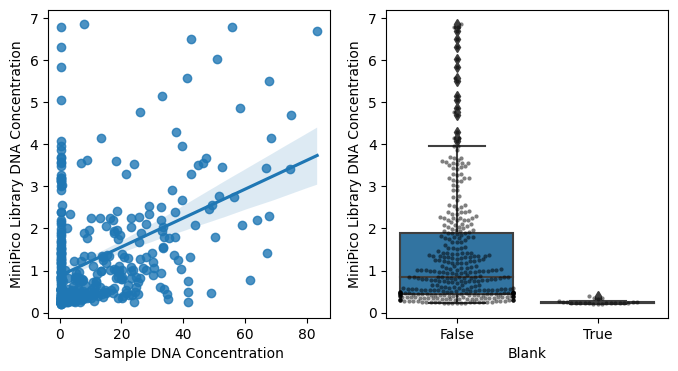

In [93]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.regplot(x="Sample DNA Concentration", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax1);
sns.boxplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2);
sns.swarmplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2,
              size=3,color='black',alpha=0.5)

In [94]:
blanks_gdna_concs = plate_df.loc[plate_df['Blank']==True,'Sample DNA Concentration']
samples_gdna_concs = plate_df.loc[plate_df['Blank']==False,'Sample DNA Concentration']
mannwhitneyu(samples_gdna_concs, blanks_gdna_concs)

MannwhitneyuResult(statistic=6887.0, pvalue=1.1582043511494799e-07)

In [95]:
blanks_lib_concs = plate_df.loc[plate_df['Blank']==True,'MiniPico Library Concentration']
samples_lib_concs = plate_df.loc[plate_df['Blank']==False,'MiniPico Library Concentration']
mannwhitneyu(samples_lib_concs, blanks_lib_concs)

MannwhitneyuResult(statistic=8006.0, pvalue=8.194331679290824e-14)

### Library concentration heatmap, whole plate

In [96]:
# get concentration and pooling values for plotting
concs = make_2D_array(plate_df, data_col="MiniPico Library Concentration", well_col=well_col).astype(float)
dna = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)
i5 = make_2D_array(plate_df, data_col='i5 name', well_col=well_col)
i7 = make_2D_array(plate_df, data_col='i7 name', well_col=well_col)

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


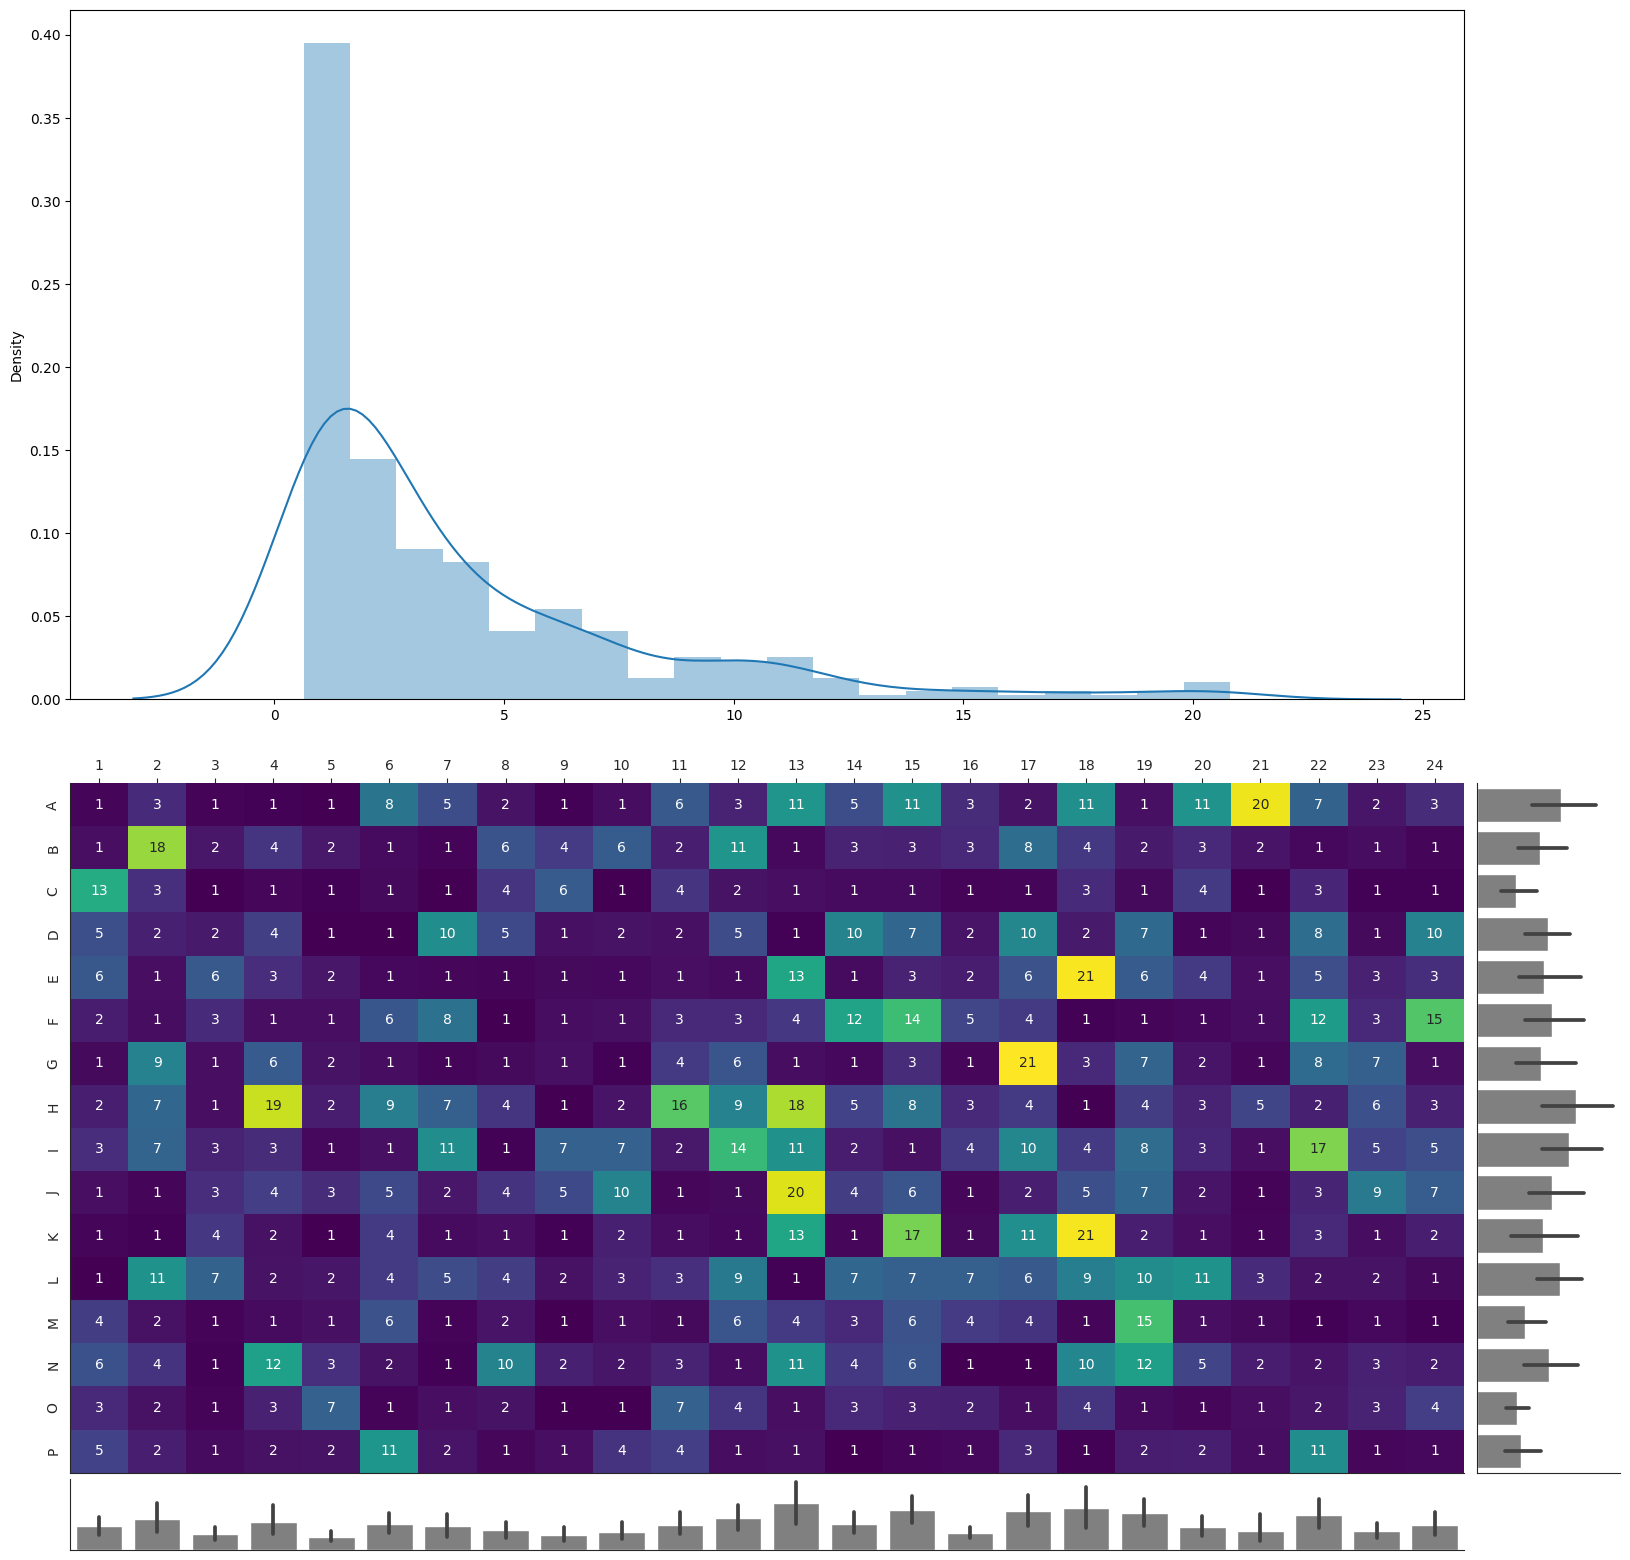

In [97]:
plot_plate_vals(concs, color_map='viridis')

### Plate maps for individual constituent plates

### Library concentration heatmap, Plate 1

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


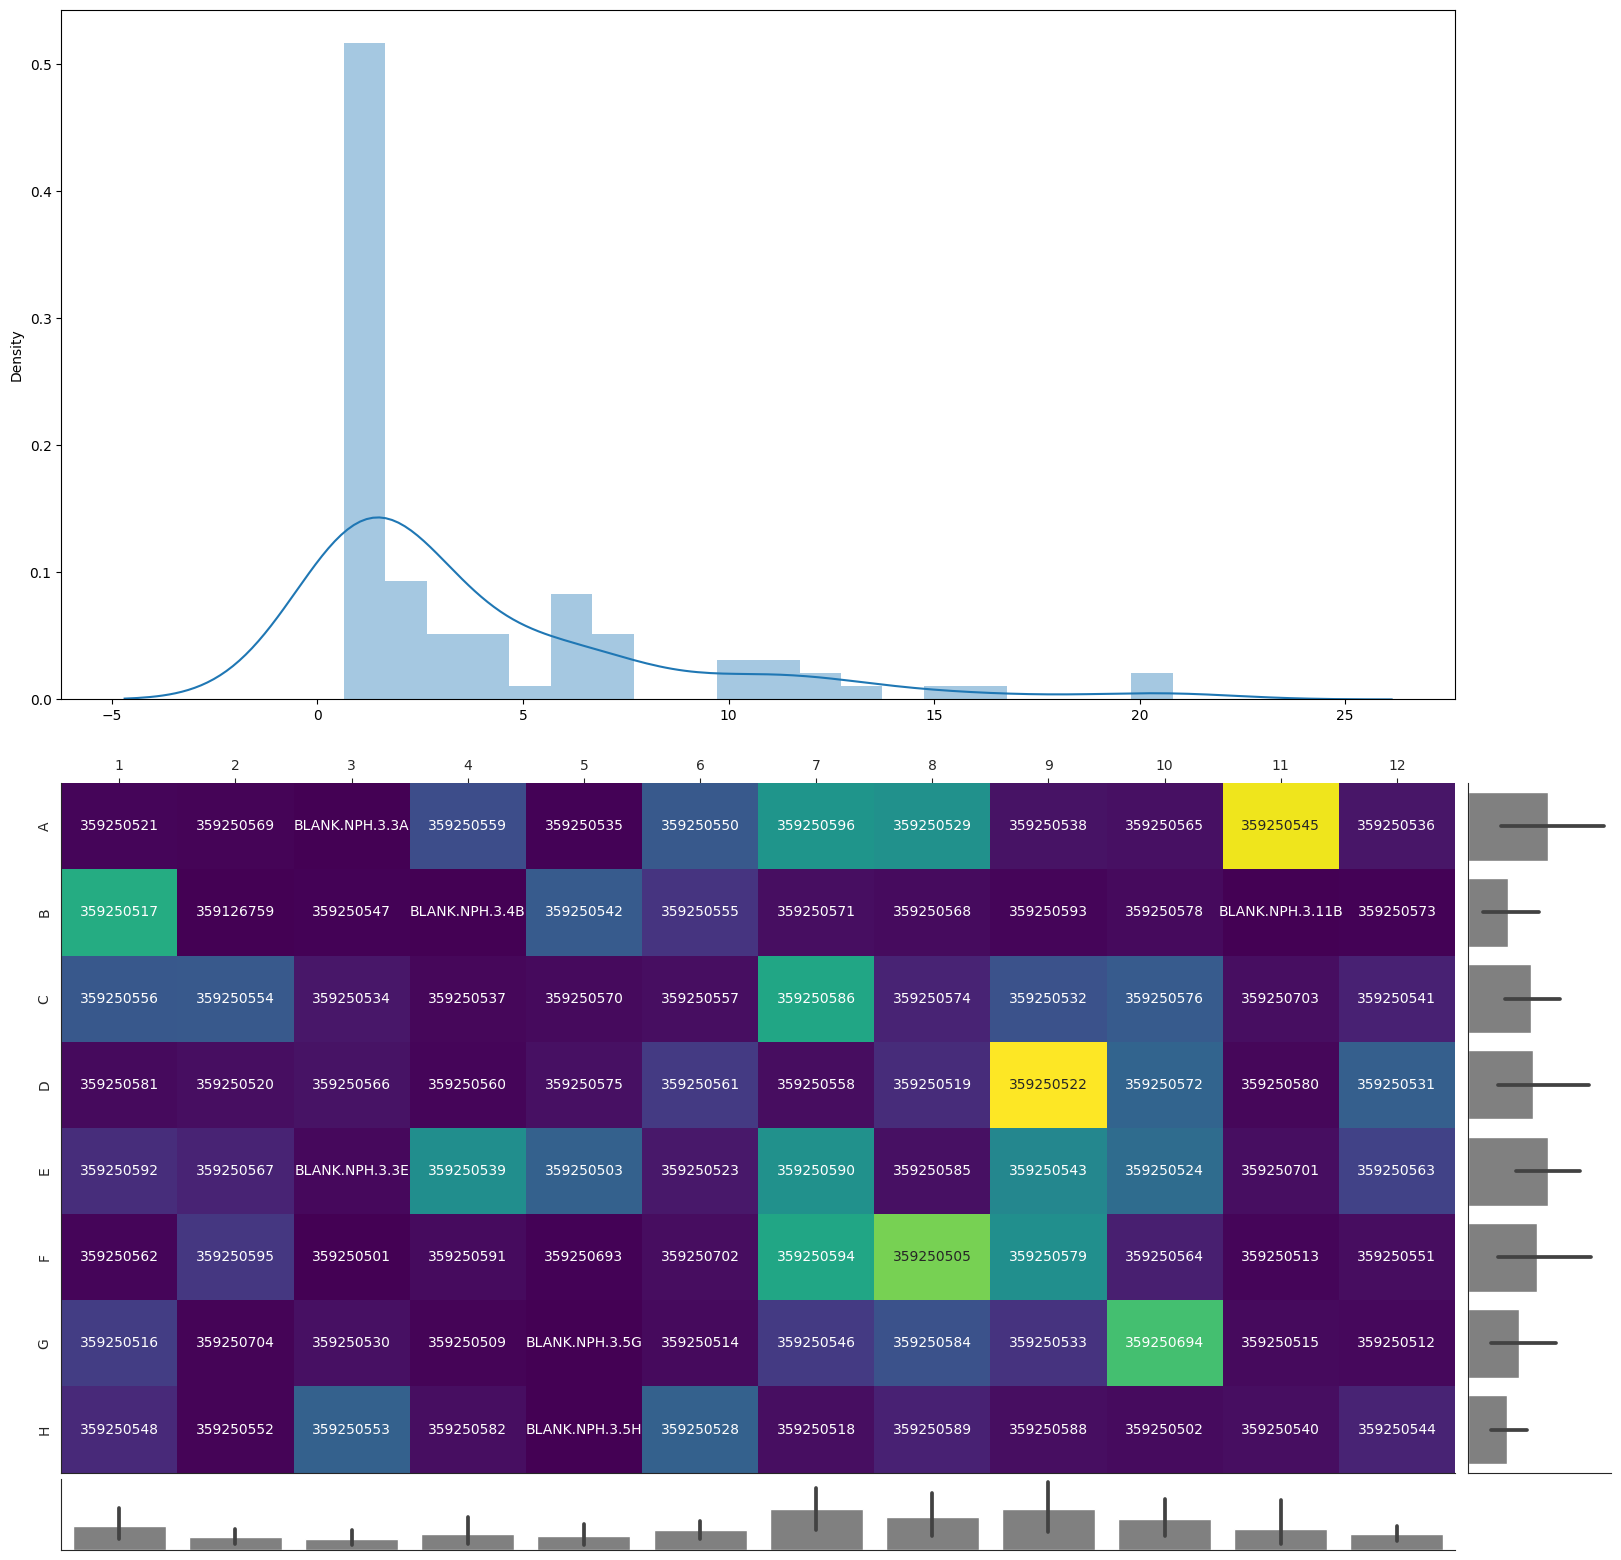

In [98]:
plot_plate_vals(concs[np.ix_(even_rows,even_cols)],
                    annot_str= names[np.ix_(even_rows,even_cols)],
                    color_map='viridis',
                    annot_fmt='')

### Library concentration heatmap, Plate 2

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


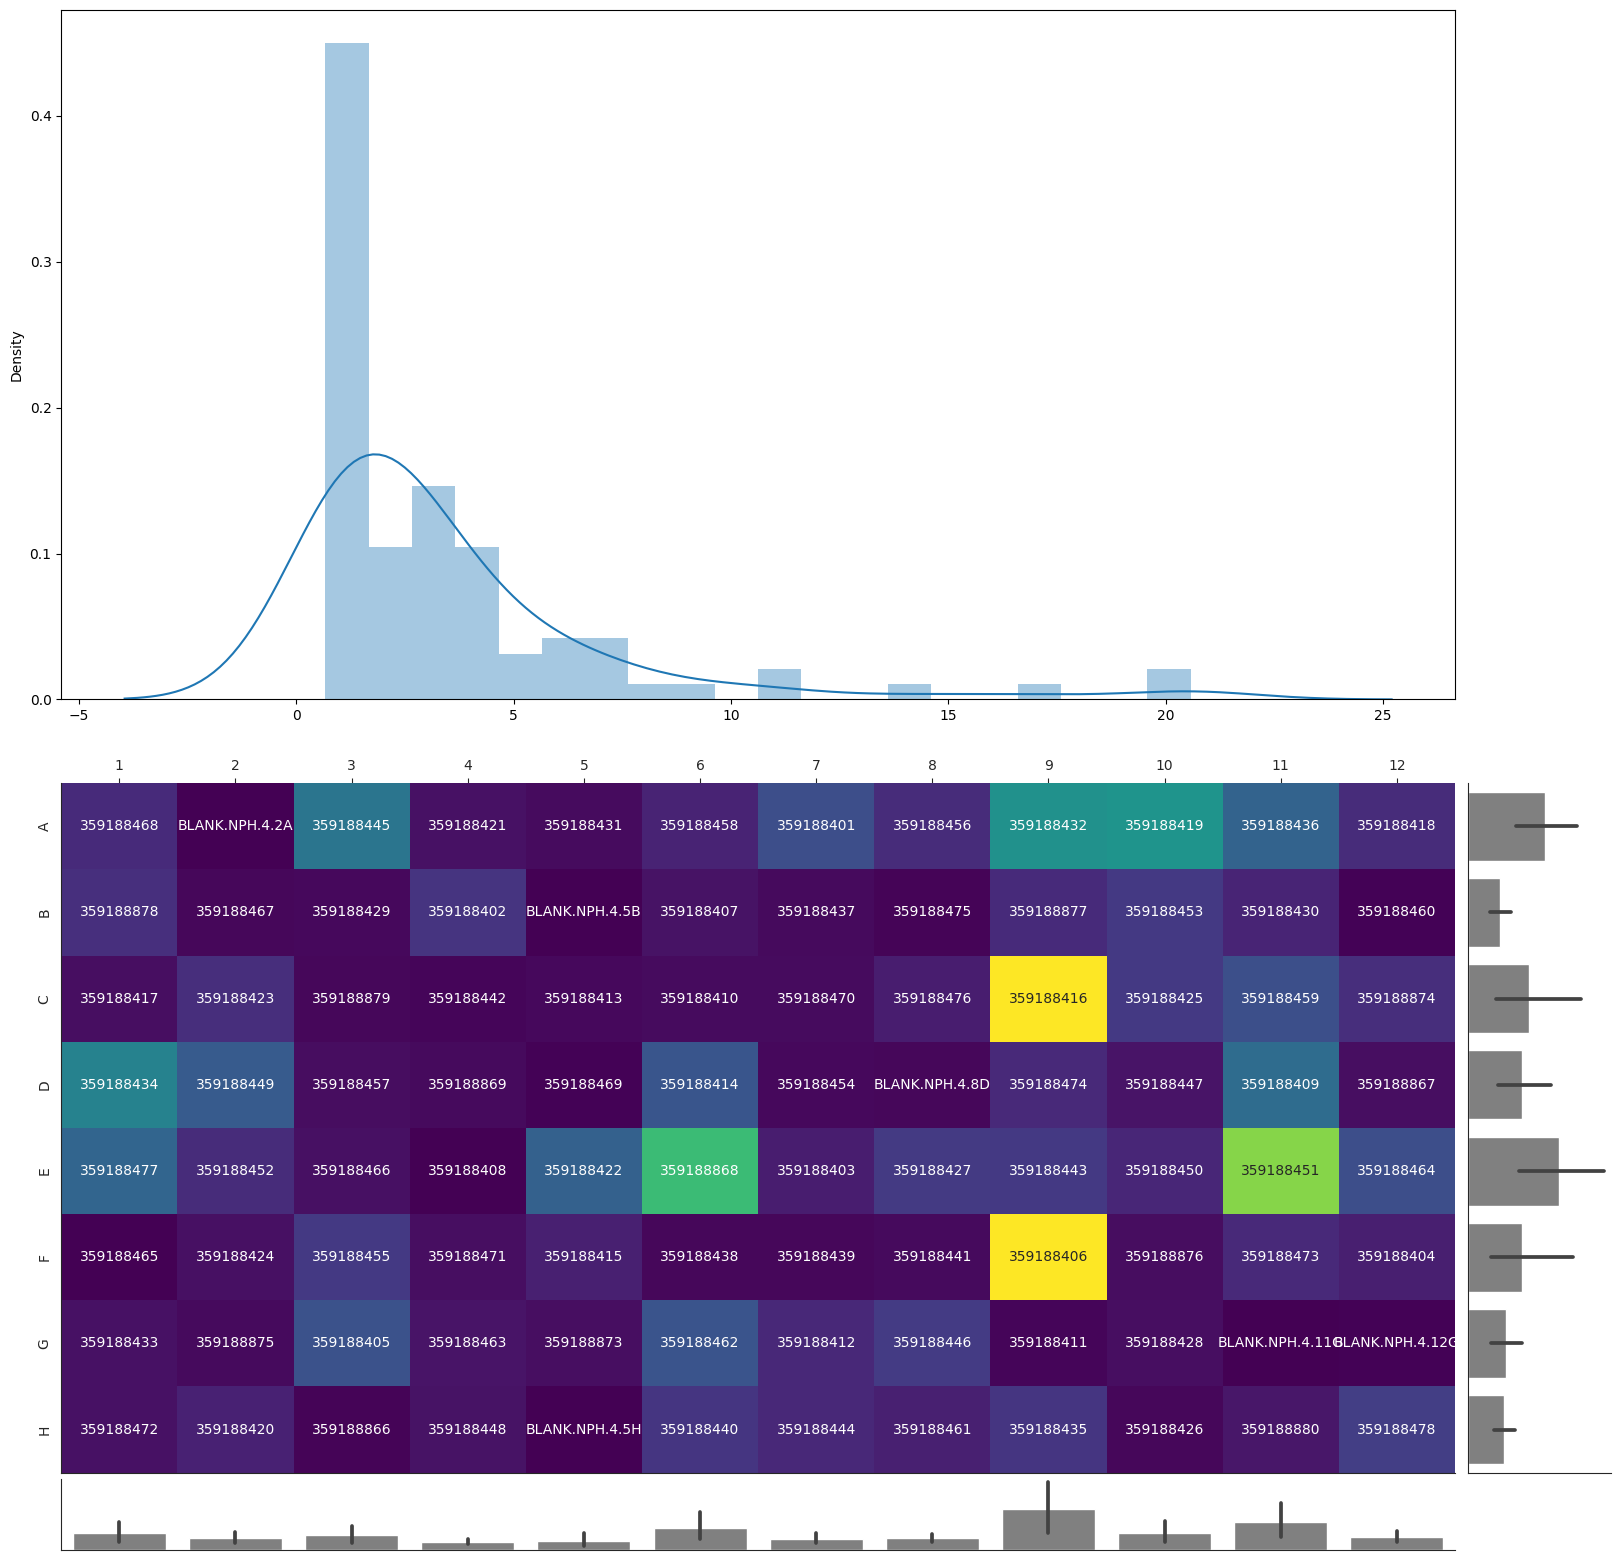

In [99]:
plot_plate_vals(concs[np.ix_(even_rows,odd_cols)],
                    annot_str= names[np.ix_(even_rows,odd_cols)],
                    color_map='viridis',
                    annot_fmt='')

### Library concentration heatmap, Plate 3

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


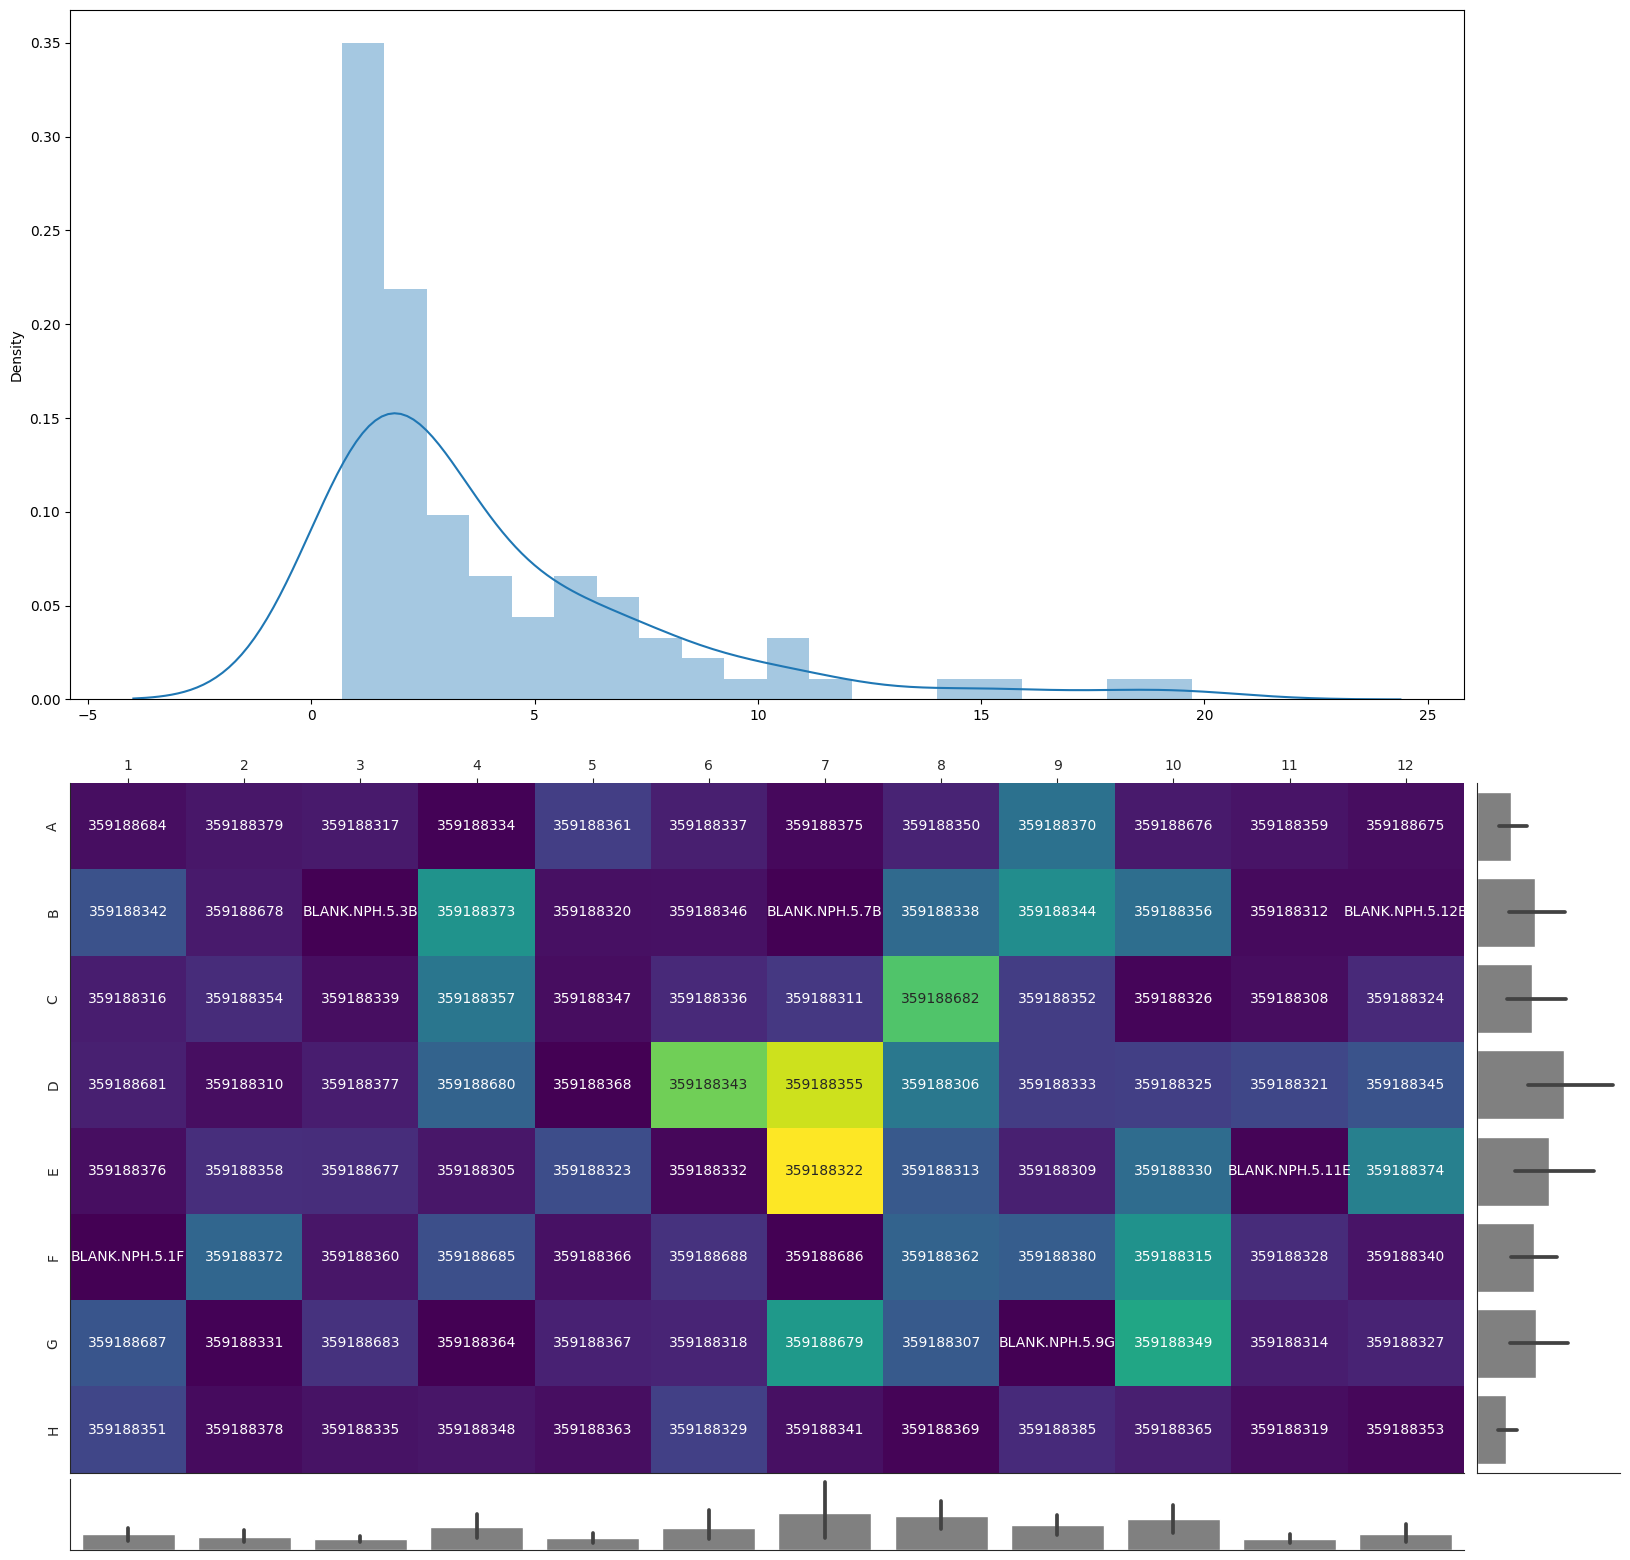

In [100]:
plot_plate_vals(concs[np.ix_(odd_rows,even_cols)],
                    annot_str= names[np.ix_(odd_rows,even_cols)],
                    color_map='viridis',
                    annot_fmt='')

### Library concentration heatmap, Plate 4

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


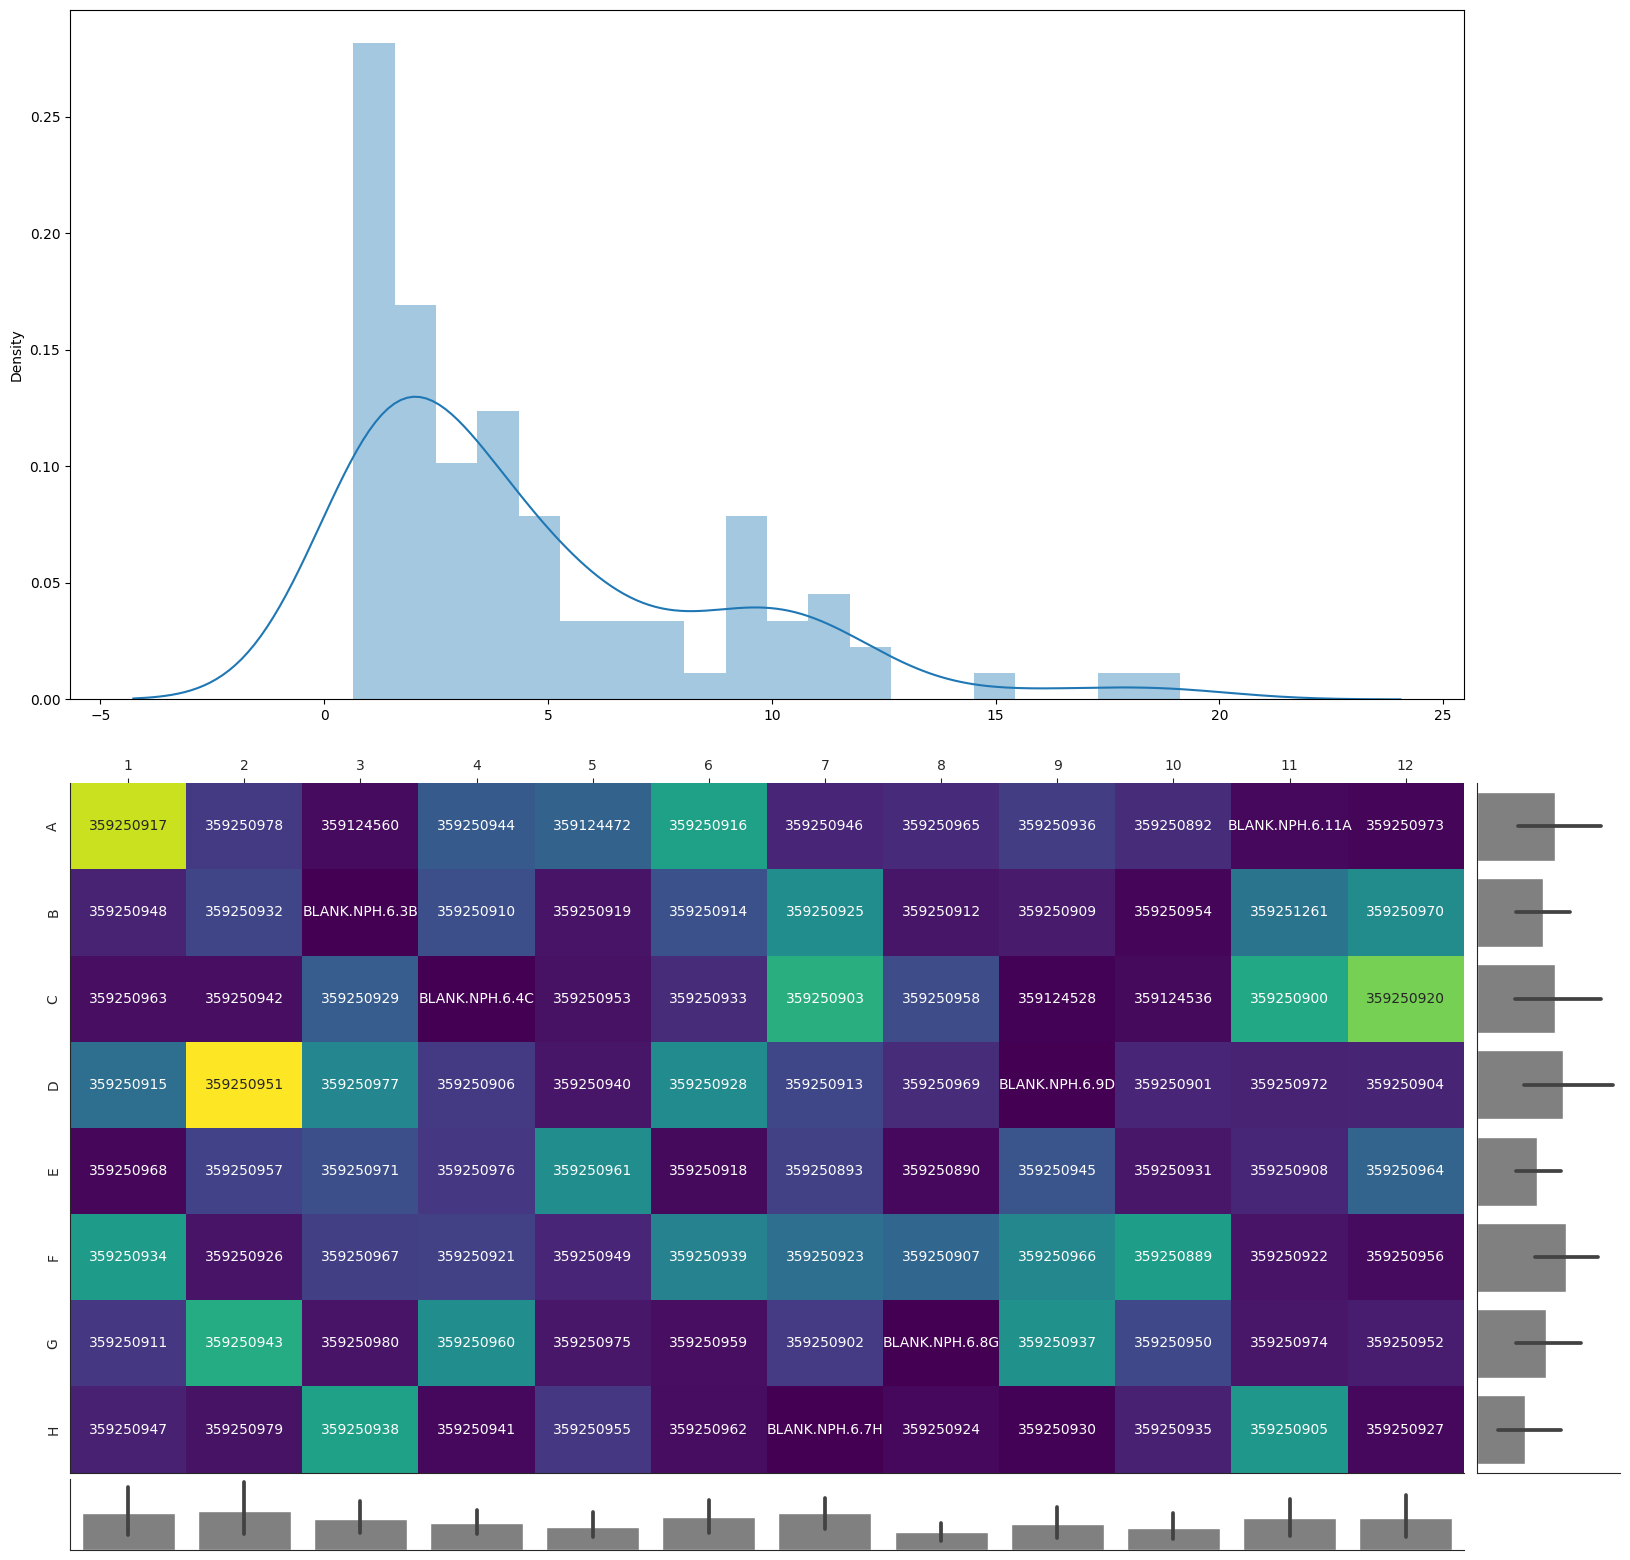

In [101]:
plot_plate_vals(concs[np.ix_(odd_rows,odd_cols)],
                    annot_str= names[np.ix_(odd_rows,odd_cols)],
                    color_map='viridis',
                    annot_fmt='')

## Step 4: calculate pooling values for MiniPico with autopool

This step will calculate the sample pooling, and update the sample data frame with the pool info.
There are two automated methods to pool:
1. **norm**: This will attempt to generate a normalized pool, automatically infering the best parameter for pooling.
    - ***pool_failures***:
        - _high_: will pool failures at the highest pooling volume from optimized pooling.
        - _low_: will pool failures at the lowest pooling volume from optimized pooling.

2. **evp**: This will pool an even volume per sample.
    - ***total_vol***: (Optional, Default: 100µL) The total volume to pool, in uL. Each sample will be pooled at 1/N of that volume.

3. **automate**: (Optional, Default = True) When False, this argument will allow one input parameters for **Legacy** arguments. 

> **Legacy**
> There are legacy parameters to control pooling behaviors when autopool automation (automate=True) returns a poor result. To use these parameters, one must pass automate=False.

>   - **min_conc**: (default: 0) This is the minimum concentration for a sample to be considered for pooling.
    Set to 0 to pool all samples, regardless of concentration. Increasing this will have the 
    effect of increasing pool concentration, at the expense of samples dropping out. 
>   - **floor_conc**: This is the lowest concentration equivalent for which a sample will be 
    accurately pooled. Samples below this concentration will be pooled to the volume that they 
    would have been if they were actually that concentration. For example, if `floor_conc=20`, 
    and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 
    10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect 
    of increasing pool concentration, but decreasing read counts for low-concentration samples. 
>   - **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing
    this will increase the overall volume of the pool.


### Calculate and plot pooling volumes

Floor concentration: 0.6393939393939394
Pool concentration: 4.00
Pool volume: 190000.00


/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


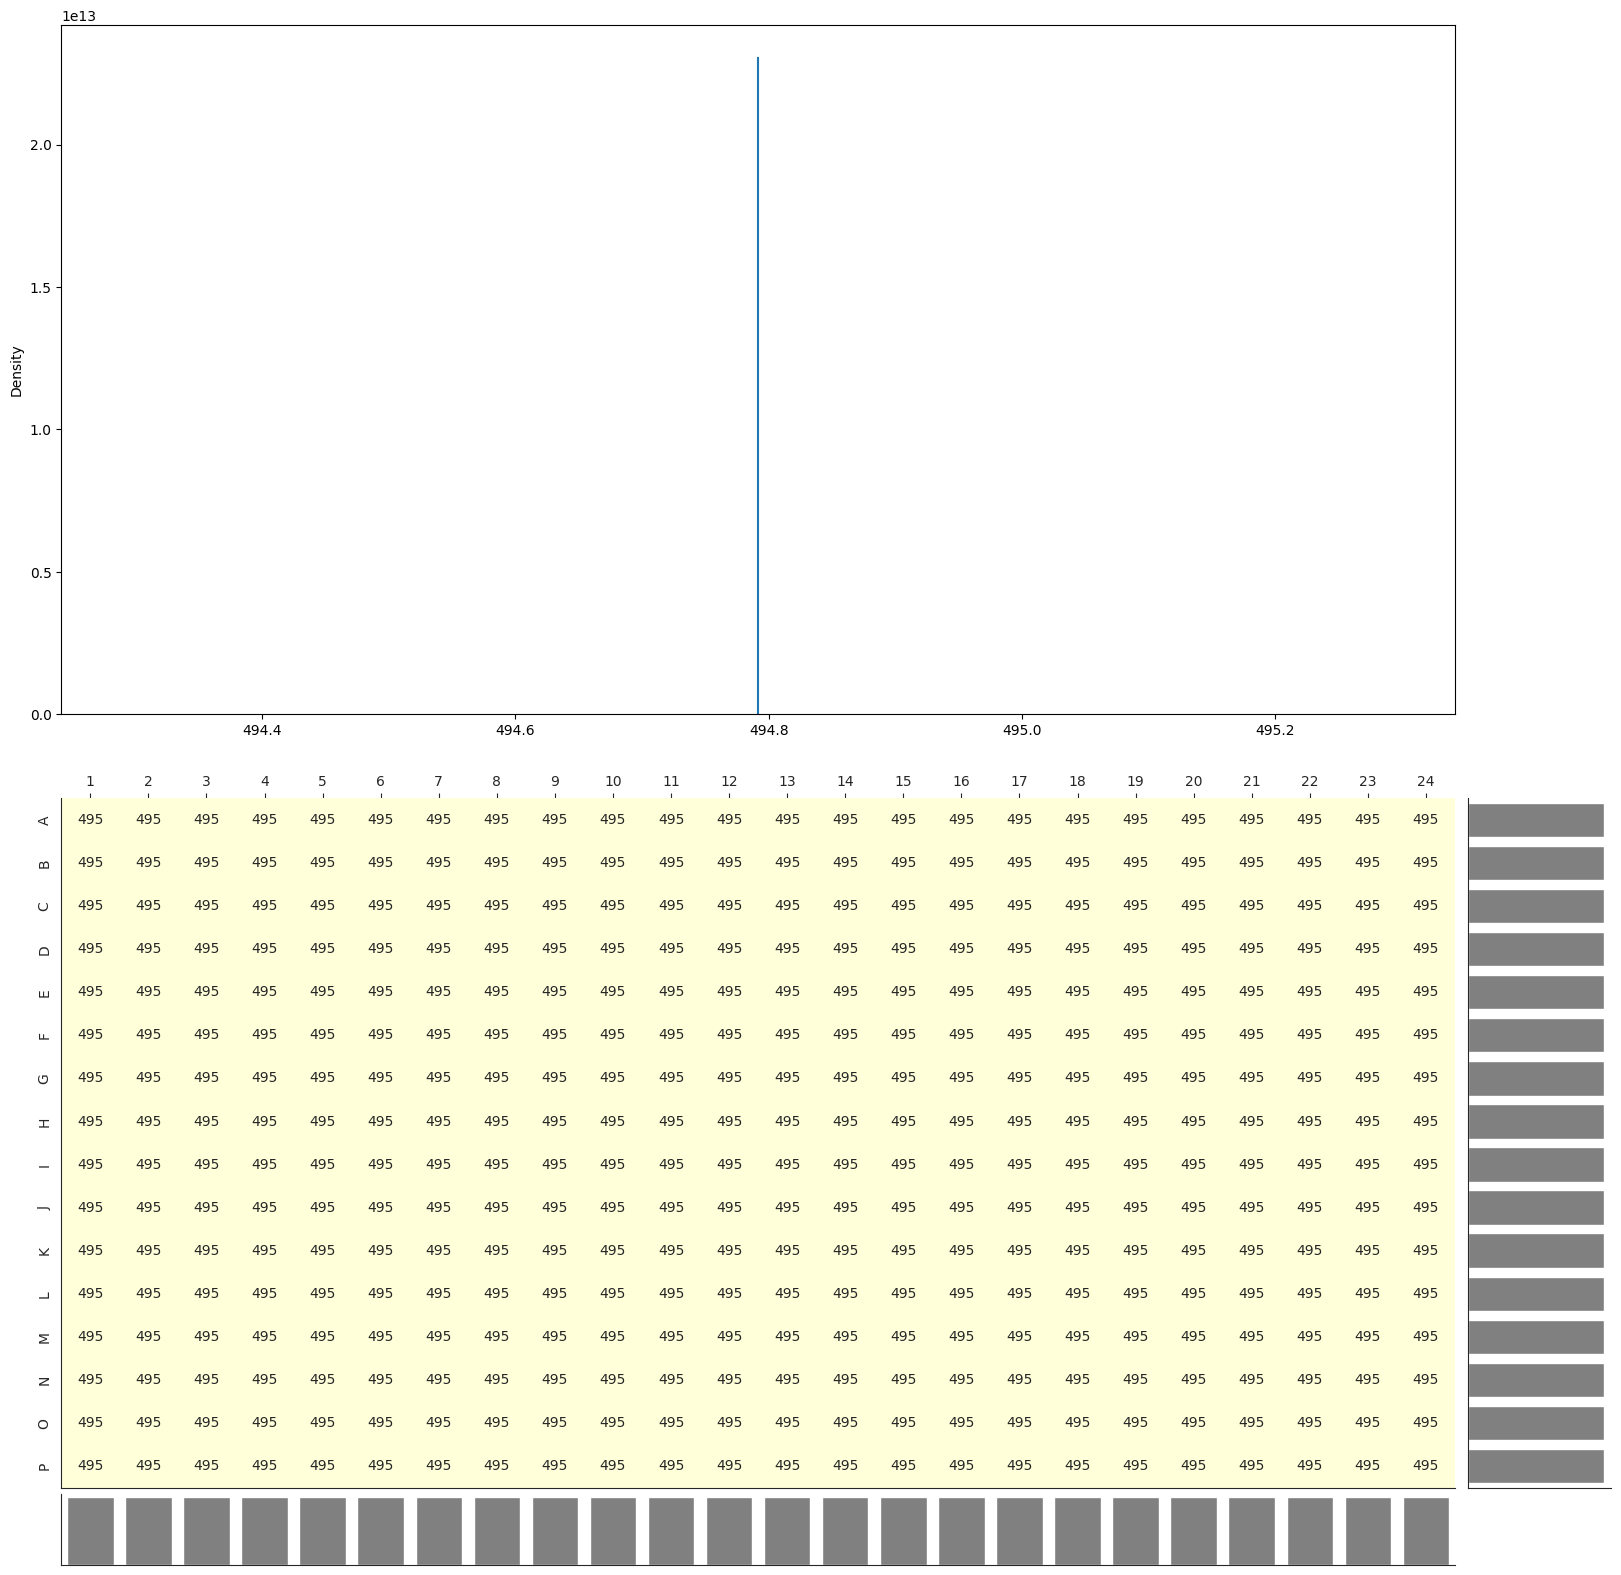

In [102]:
threshold = find_threshold(plate_df['MiniPico Library Concentration'], plate_df['Blank'])
plate_df = autopool(plate_df,method='evp',total_vol=190)

# visualize
print("Floor concentration: {}".format(threshold))
vols = make_2D_array(plate_df, data_col='MiniPico Pooled Volume', well_col=well_col).astype(float)
conc, vol = estimate_pool_conc_vol(plate_df['MiniPico Pooled Volume'], plate_df['MiniPico Library Concentration'])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

<Axes: xlabel='MiniPico Library Concentration', ylabel='MiniPico Pooled Volume'>

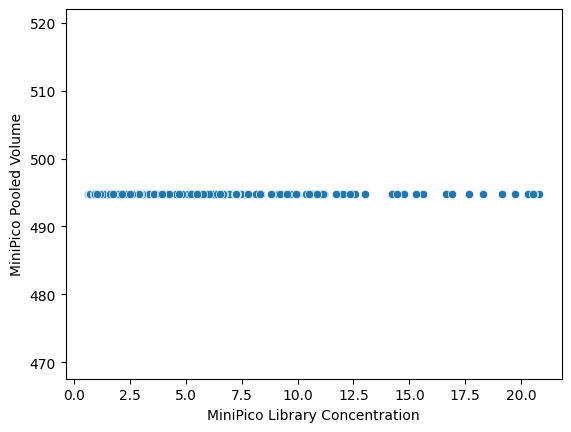

In [103]:
vols = make_2D_array(plate_df, data_col='MiniPico Pooled Volume', well_col=well_col).astype(float)
sns.scatterplot(x='MiniPico Library Concentration', y='MiniPico Pooled Volume',data=plate_df)

## Step 5: write pooling pick list

In [104]:
# Write the picklist as .csv
picklist_fp = './test_output/Pooling/YYYY_MM_DD_NPH_3-6_evp.csv'

if os.path.isfile(picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [105]:
picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)
with open(picklist_fp,'w') as f:
    f.write(picklist)

!head {picklist_fp}

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2,A1,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A2,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A3,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A4,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A5,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A6,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A7,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A8,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A9,,494.79,NormalizedDNA,A1


# Write DataFrame to file

We want to keep all that useful information together in one place so it can be easily parsed later. 

In [106]:
# Write the sample info DataFrame as .txt
plate_df_fp = './test_output/QC/YYYY_MM_DD_NPH_3-6_df.txt'

if os.path.isfile(plate_df_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [107]:
plate_df.to_csv(plate_df_fp, sep='\t')

# Make sample sheet

This workflow takes the pooled sample information and writes an Illumina sample sheet that can be given directly to the sequencing center. 

As inputs, this notebook requires:
1. A plate map DataFrame (from previous step)

The workflow:
1. formats sample names as bcl2fastq-compatible
2. formats sample data
3. sets values for sample sheet fields and formats sample sheet.
4. writes the sample sheet to a file

## Step 1: Format sample names to be bcl2fastq-compatible

bcl2fastq requires *only* alphanumeric, hyphens, and underscore characters. We'll replace all non-those characters
with underscores and add the bcl2fastq-compatible names to the DataFrame.

In [108]:
plate_df['sample sheet Sample_ID'] = plate_df['Sample'].map(bcl_scrub_name)

plate_df.head()

Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  ...  i5 well     i5 plate  \
0         A1                      Q1   A1  ...       A1  iTru5_plate   
1         B1                      Q1   C1  ...       A3  iTru5_plate   
2         C1                      Q1   E1  ...       A5  iTru5_plate   
3         D1                      Q1   G1  ...       A7  iTru5_plate   
4         E1                      Q1   I1  ...       A9  iTru5_plate   

        i7 name  i7 sequence i7 well     i7 plate  \
0  iTru7_206_12     ATGCCAAC     H23  iTru7_plate   
1  iTru7_207_01     CACGTTGT      J1  iTru7_plate   
2  iTru7_207_02     TATTCCGG      J3  iTru7_plate   
3  iTru7_207_03     TGCTTCCA      J5  iTru7_plate   
4  iTru7_207_04     GTCTAGGT      J7  iTru7_plate   

   MiniPico Library DNA Concentration  MiniPico Library Concentration  \
0                               0.304                        0.921212   
1                               4.297                       13.021212   
2                               2.009                        6.087879   
3                               0.368                        1.115152   
4                               1.048                        3.175758   

  MiniPico Pooled Volume sample sheet Sample_ID  
0             494.791667              359250521  
1             494.791667              359250517  
2             494.791667              359250556  
3             494.791667              359250581  
4             494.791667              359250592  

[5 rows x 31 columns]

## Step 2: format sample sheet data

This step formats the data columns appropriately for the sample sheet, using the values we've calculated previously.

The newly-created bcl2fastq-compatible names will be in the **`Sample ID`** and **`Sample Name`** columns. The
original sample names will be in the **`Description`** column.

Modify **`lanes`** to indicate which lanes this pool will be sequenced on.

**Project Name and Project Plate values will be placed in the **`Sample_Project`** and **`Sample_Name`**
columns, respectively.

**`sequencer`** is important for making sure the i5 index is in the correct orientation for demultiplexing. `NovaSeq6000`, `HiSeq4000`, `HiSeq3000`, `NextSeq`, `MiniSeq`, and `iSeq` all require reverse-complemented i5 index sequences. If you enter one of these exact strings in for `sequencer`, it will revcomp the i5 sequence for you.

`HiSeq2500`, `MiSeq`, `NovaSeqX`, and `NovaSeqXPlus` will not revcomp the i5 sequence. 

In [109]:
sequencer = 'iSeq'
lanes = [1]
plate_df['vol_extracted_elution_ul'] = 70

# Knight Lab Nextera is also valid for library_construction_protocol
metadata = {
    'Bioinformatics': [
        {
         'Sample_Project': 'NPH_15288',
         'QiitaID': '15288',
         'BarcodesAreRC': 'True',
         'ForwardAdapter': 'GATCGGAAGAGCACACGTCTGAACTCCAGTCAC',
         'ReverseAdapter': 'GATCGGAAGAGCGTCGTGTAGGGAAAGGAGTGT',
         'HumanFiltering': 'True',
         'library_construction_protocol': 'Knight Lab Kapa HyperPlus',
         'experiment_design_description': 'stool metatranscriptomics',
         'contains_replicates':plate_df['contains_replicates'].all(),
        },
    ],
    'Contact': [
        {
         'Sample_Project': 'NPH_15288',
         # non-admin contacts who want to know when the sequences
         # are available in Qiita
         'Email': 'klwetlab@health.ucsd.edu'
        },
    ],
    'Assay': 'Metatranscriptomic',
    'SheetType': 'standard_metat',
    'SheetVersion':'10'
}

sheet = make_sample_sheet(metadata, plate_df, sequencer, lanes)

iSeq: i5 barcodes are output as reverse compliments


## Step 3: Write the sample sheet to file

In [110]:
# Write the samplesheet as .csv
sample_sheet_fp = './test_output/SampleSheets/YYYY_MM_DD_NPH_3-6_metaT_samplesheet_iSeq_240.csv'

if os.path.isfile(sample_sheet_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [111]:
with open(sample_sheet_fp,'w') as f:
    sheet.write(f)
    
!head -n 30 {sample_sheet_fp}
!echo ...
!tail -n 15 {sample_sheet_fp}

[Header],,,,,,,,,,,,
IEMFileVersion,4,,,,,,,,,,,
SheetType,standard_metat,,,,,,,,,,,
SheetVersion,10,,,,,,,,,,,
Investigator Name,Knight,,,,,,,,,,,
Experiment Name,RKL_experiment,,,,,,,,,,,
Date,2024-04-01,,,,,,,,,,,
Workflow,GenerateFASTQ,,,,,,,,,,,
Application,FASTQ Only,,,,,,,,,,,
Assay,Metatranscriptomic,,,,,,,,,,,
Description,,,,,,,,,,,,
Chemistry,Default,,,,,,,,,,,
,,,,,,,,,,,,
[Reads],,,,,,,,,,,,
151,,,,,,,,,,,,
151,,,,,,,,,,,,
,,,,,,,,,,,,
[Settings],,,,,,,,,,,,
ReverseComplement,0,,,,,,,,,,,
,,,,,,,,,,,,
[Data],,,,,,,,,,,,
Sample_ID,Sample_Name,Sample_Plate,well_id_384,I7_Index_ID,index,I5_Index_ID,index2,Sample_Project,total_rna_concentration_ng_ul,vol_extracted_elution_ul,Well_description,Lane
359250521,359250521,NPH_15288_P3,A1,iTru7_206_12,ATGCCAAC,iTru5_01_A,TTGTCGGT,NPH_15288,8.353,70,NPH_15288_P3.359250521.A1,1
359250517,359250517,NPH_15288_P3,C1,iTru7_207_01,CACGTTGT,iTru5_02_A,TTGCGAAG,NPH_15288,75.672,70,NPH_15288_P3.359250517.C1,1
359250556,359250556,NPH_15288_P3,E1

# Read Distribution Summary and Pool Normalization

## Step 1: import and merge per_sample read distributions

Import a tsv file with read_counts from per_sample_fastq files and merge with growing plate_df


In [112]:
# Import reads counts from file to dataframes

read_counts_df = pd.read_csv('./test_data/Demux/YYYY_MM_DD_NPH_3-6_fastqc_sequence_counts.tsv',
                                 sep='\t')
raw_read_counts_df = read_counts_df.loc[~read_counts_df['Category'].str.contains('trimmed')]
filtered_read_counts_df = read_counts_df.loc[read_counts_df['Category'].str.contains('trimmed')]

##Can also import counts from Qiita per_sample_FASTQ summaries.  
# per_sample_fastq_counts_df = pd.read_csv('./test_data/Demux/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_per_sample_fastq.tsv',
#                                          sep='\t')

In [113]:
# Merge read_counts_df with plate_df 

plate_df_w_reads = merge_read_counts(plate_df,raw_read_counts_df, reads_column_name='Raw Reads')

plate_df_w_reads = merge_read_counts(plate_df_w_reads,filtered_read_counts_df,
                                     reads_column_name='Filtered Reads')

# plate_df_w_reads = merge_read_counts(plate_df_w_reads,per_sample_fastq_counts_fp,
#                                      reads_column_name='Qiita Reads')

plate_df_w_reads.head()

/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:1223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_df.loc[i, 'Sample'] = sample_id
/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:1223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_df.loc[i, 'Sample'] = sample_id


Sample Row  Col  Blank Project Plate Project Name Compressed Plate Name  \
0  359250521   A    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
1  359250517   C    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
2  359250556   E    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
3  359250581   G    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   
4  359250592   I    1  False  NPH_15288_P3    NPH_15288         NPH_15288_3-6   

  well_id_96 plate_position_quadrant Well  ...  i7 sequence  i7 well  \
0         A1                      Q1   A1  ...     ATGCCAAC      H23   
1         B1                      Q1   C1  ...     CACGTTGT       J1   
2         C1                      Q1   E1  ...     TATTCCGG       J3   
3         D1                      Q1   G1  ...     TGCTTCCA       J5   
4         E1                      Q1   I1  ...     GTCTAGGT       J7   

      i7 plate  MiniPico Library DNA Concentration  \
0  iTru7_plate                               0.304   
1  iTru7_plate                               4.297   
2  iTru7_plate                               2.009   
3  iTru7_plate                               0.368   
4  iTru7_plate                               1.048   

  MiniPico Library Concentration  MiniPico Pooled Volume  \
0                       0.921212              494.791667   
1                      13.021212              494.791667   
2                       6.087879              494.791667   
3                       1.115152              494.791667   
4                       3.175758              494.791667   

   sample sheet Sample_ID  vol_extracted_elution_ul Raw Reads Filtered Reads  
0               359250521                        70    1304.0         1054.0  
1               359250517                        70       NaN        62716.0  
2               359250556                        70   25764.0            NaN  
3               359250581                        70       NaN          702.0  
4               359250592                        70   11654.0        10354.0  

[5 rows x 34 columns]

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


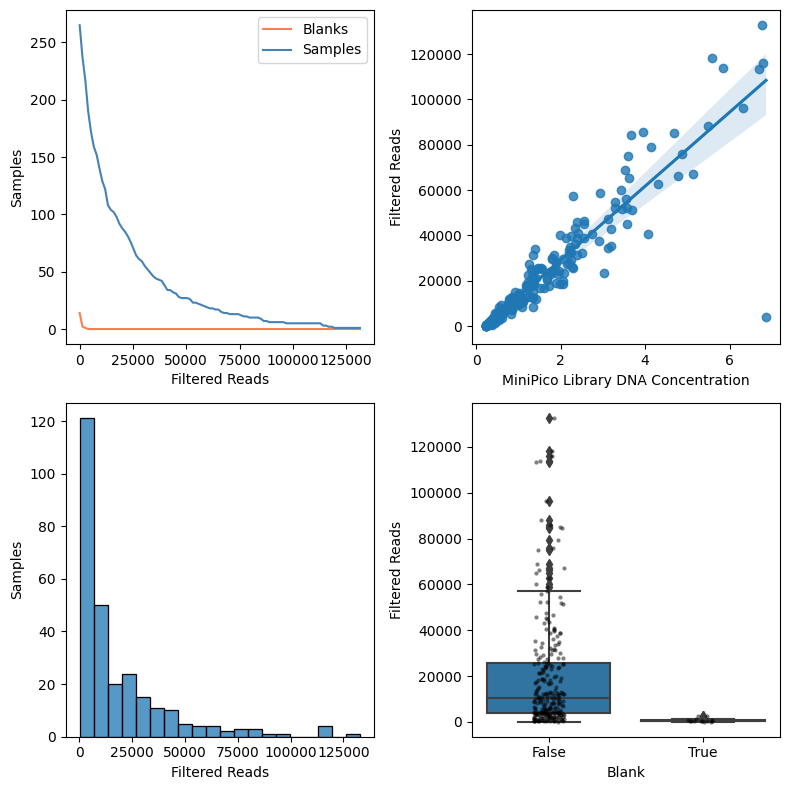

In [119]:
reads_column = 'Filtered Reads'

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# evenness plot
rmax = int(round(plate_df_w_reads[reads_column].max(),-2))
survival_df = pd.concat([read_survival(plate_df_w_reads.loc[plate_df_w_reads['Blank'] == True,
                                                            reads_column], label='Blanks',rmax=rmax),
                         read_survival(plate_df_w_reads.loc[plate_df_w_reads['Blank'] == False,
                                                            reads_column], label='Samples',rmax=rmax)])

ax3.set_xlabel(reads_column)
ax3.set_ylabel('Samples')
survival_df.plot(color = ['coral','steelblue'],ax=ax1)
ax1.set_xlabel(reads_column)
ax1.set_ylabel('Samples')

##Histogram
sns.histplot(plate_df_w_reads[reads_column],ax=ax3)

##Regressopm
sns.regplot(x="MiniPico Library DNA Concentration", y=reads_column, data=plate_df_w_reads, ax = ax2);

#Boxplot
sns.boxplot(x="Blank", y=reads_column, data=plate_df_w_reads, ax = ax4);
sns.stripplot(x="Blank", y=reads_column, data=plate_df_w_reads, ax = ax4,
              size=3,color='black',alpha=0.5)


plt.tight_layout()

In [125]:
plate_df_w_reads.sort_values(by='MiniPico Library DNA Concentration')[['Raw R]]

Sample Row  Col  Blank Project Plate Project Name  \
39   BLANK.NPH.3.5H   O    9   True  NPH_15288_P3    NPH_15288   
314  BLANK.NPH.6.4C   F    8   True  NPH_15288_P6    NPH_15288   
305  BLANK.NPH.6.3B   D    6   True  NPH_15288_P6    NPH_15288   
9         359126759   C    3  False  NPH_15288_P3    NPH_15288   
350  BLANK.NPH.6.8G   N   16   True  NPH_15288_P6    NPH_15288   
..              ...  ..  ...    ...           ...          ...   
244       359188322   J   13  False  NPH_15288_P5    NPH_15288   
80        359250545   A   21  False  NPH_15288_P3    NPH_15288   
165       359188406   K   18  False  NPH_15288_P4    NPH_15288   
162       359188416   E   18  False  NPH_15288_P4    NPH_15288   
67        359250522   G   17  False  NPH_15288_P3    NPH_15288   

    Compressed Plate Name well_id_96 plate_position_quadrant Well  ...  \
39          NPH_15288_3-6         H5                      Q1   O9  ...   
314         NPH_15288_3-6         C4                      Q4   F8  ...   
305         NPH_15288_3-6         B3                      Q4   D6  ...   
9           NPH_15288_3-6         B2                      Q1   C3  ...   
350         NPH_15288_3-6         G8                      Q4  N16  ...   
..                    ...        ...                     ...  ...  ...   
244         NPH_15288_3-6         E7                      Q3  J13  ...   
80          NPH_15288_3-6        A11                      Q1  A21  ...   
165         NPH_15288_3-6         F9                      Q2  K18  ...   
162         NPH_15288_3-6         C9                      Q2  E18  ...   
67          NPH_15288_3-6         D9                      Q1  G17  ...   

     Filtered Reads  proportion  LoadingFactor  iSeq normpool volume  \
39              NaN         NaN      20.000000            100.000000   
314             NaN         NaN      20.000000            100.000000   
305             NaN         NaN      20.000000            100.000000   
9               NaN         NaN      20.000000            500.000000   
350             NaN         NaN      20.000000            100.000000   
..              ...         ...            ...                   ...   
244             NaN         NaN      20.000000            500.000000   
80         113428.0    0.022001       1.170558             44.129288   
165        132774.0    0.025754       1.000000             40.000000   
162        116268.0    0.022552       1.141965             43.437050   
67           4076.0    0.000791      20.000000            500.000000   

    projected_reads  projected_proportion  projected_HO_reads  \
39     2.920000e+03              0.000050        1.981225e+05   
314    2.800000e+03              0.000047        1.899805e+05   
305    2.920000e+03              0.000050        1.981225e+05   
9      2.600000e+03              0.000044        1.764105e+05   
350    3.840000e+03              0.000065        2.605447e+05   
..              ...                   ...                 ...   
244    2.956360e+06              0.050147        2.005896e+08   
80     2.065800e+05              0.003504        1.401649e+07   
165    1.543940e+05              0.002619        1.047566e+07   
162    1.552090e+05              0.002633        1.053096e+07   
67     2.163280e+06              0.036695        1.467789e+08   

     on_target_proportion projected_off_target_reads projected_on_target_reads  
39                    NaN                        NaN                       NaN  
314                   NaN                        NaN                       NaN  
305                   NaN                        NaN                       NaN  
9                     NaN                        NaN                       NaN  
350                   NaN                        NaN                       NaN  
..                    ...                        ...                       ...  
244                   NaN                        NaN                       NaN  
80               0.642724            

## Step 2: Calculate iSeqnorm pooling volumes

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


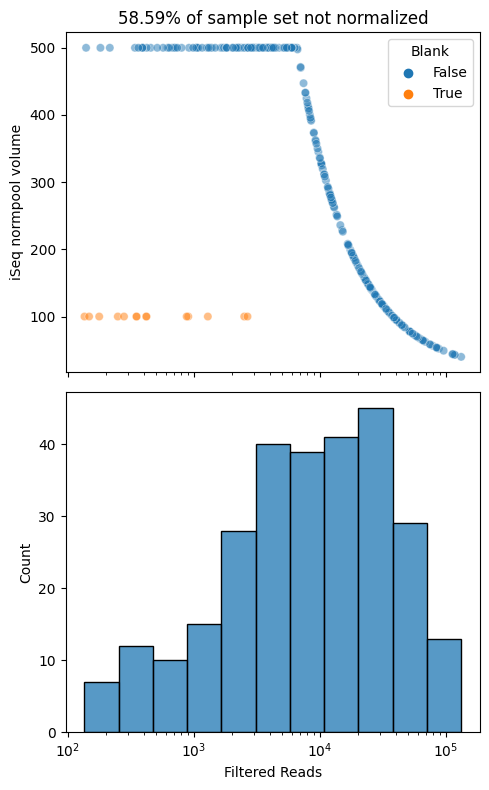

In [122]:
plate_df_normalized = calculate_iseqnorm_pooling_volumes(plate_df_w_reads,dynamic_range=20)

Pool concentration: 3.02
Pool volume: 134358.22


/Users/rodolfoantoniosalidobenitez/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:954: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


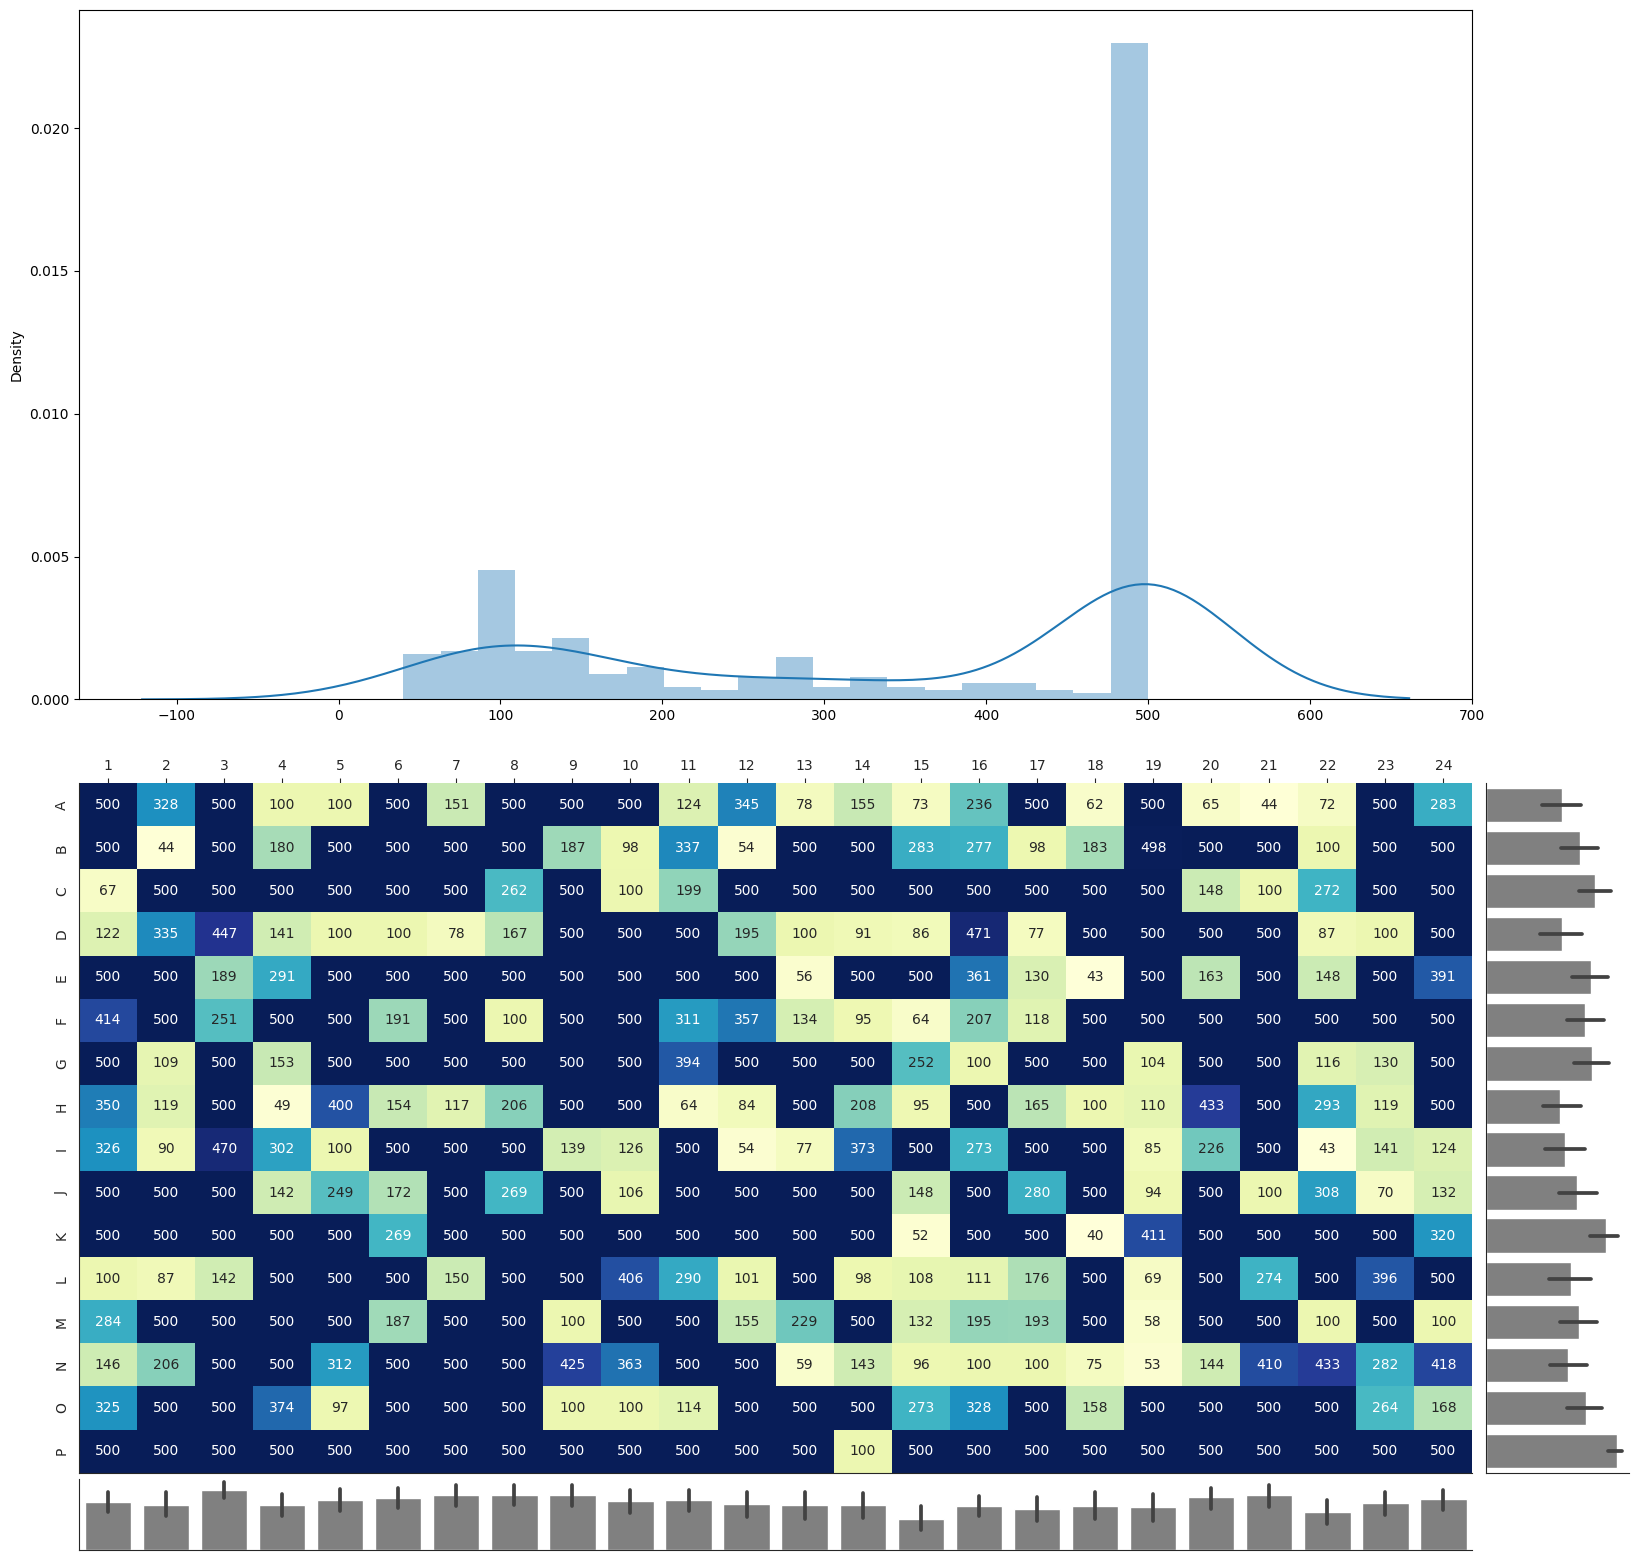

In [123]:
# visualize
vols = make_2D_array(plate_df_normalized, data_col='iSeq normpool volume', well_col=well_col).astype(float)
conc, vol = estimate_pool_conc_vol(plate_df_normalized['iSeq normpool volume'], plate_df_normalized['MiniPico Library Concentration'])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

## Estimate read depth

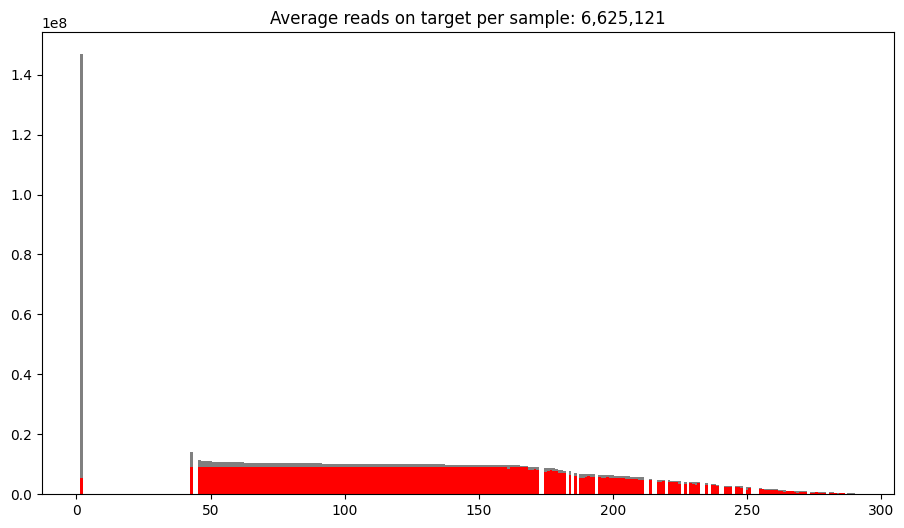

In [124]:
#Plots estimate of read depth proportion, and returns a df with estimates. 
plate_df_normalized_with_estimates = estimate_read_depth(plate_df_normalized)

## Step 3: write pooling picklist

In [ ]:
# Write the picklist as .csv
picklist_fp = './test_output/Pooling/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_iSeqnormpool.csv'

if os.path.isfile(picklist_fp):
    print("Warning! This file exists already.")

In [ ]:
picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)
with open(picklist_fp,'w') as f:
    f.write(picklist)

!head {picklist_fp}